In [1]:
import mediapipe as mp

"""
face_emotion_pipeline.py
End-to-end pipeline:
1) download video
2) extract frames
3) detect face & save mediapipe landmarks (CSV) + face crops
4) interactive labeling (keyboard)
5) train a custom PyTorch model on landmarks
6) run inference & visualize

Usage examples:
python face_emotion_pipeline.py --download --url "https://youtu.be/C7VUCfIXQ3U?si=KCZZyfhUUyokqOir"
python face_emotion_pipeline.py --extract_frames --video_path ./videos/video.mp4 --fps 2
python face_emotion_pipeline.py --detect_landmarks --frames_dir ./frames --out_landmarks landmarks.csv --crops_dir ./crops
python face_emotion_pipeline.py --label --crops_dir ./crops --landmarks_csv landmarks.csv --labels_out labels.csv
python face_emotion_pipeline.py --train --landmarks_csv landmarks.csv --labels_csv labels.csv --model_out model.pth
python face_emotion_pipeline.py --predict_video --video_path ./videos/video.mp4 --model_path model.pth
"""

In [3]:
import os
import argparse
import subprocess
from pathlib import Path
import cv2
import numpy as np
import pandas as pd
import mediapipe as mp
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
import matplotlib.pyplot as plt

In [2]:
# -------------------------
# Constants / Config
# -------------------------
CLASSES = ["menangis", "tertawa", "uh"]   # mapping keys: 0,1,2
NUM_LANDMARKS = 468  # mediapipe face mesh
LM_DIM = NUM_LANDMARKS * 2  # x,y per point

In [3]:
# -------------------------
# Utilities
# -------------------------
def ensure_dir(path):
    Path(path).mkdir(parents=True, exist_ok=True)

In [16]:
if __name__ == "__main__":
    url = "https://youtu.be/C7VUCfIXQ3U?si=KCZZyfhUUyokqOir"
    try:
        downloaded_path = download_youtube(url, out_dir=".", filename=None)
        print("Path video:", downloaded_path)
    except RuntimeError as err:
        print("Error:", err)


Menjalankan yt-dlp ... (pastikan yt-dlp terinstall).
Video ditemukan (fallback): C7VUCfIXQ3U.f140.m4a
Path video: D:\KULIAH\S2\Semester 2\Proposal Thesis\TugasIbuHanna Mengarah ke Tugas Akhir\Codingan\Sinta2\C7VUCfIXQ3U.f140.m4a


In [20]:
import os

def ensure_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

ensure_dir("frames")
ensure_dir("landmarks")

print("Folder frames/ dan landmarks/ sudah dibuat.")


Folder frames/ dan landmarks/ sudah dibuat.


In [2]:
def ensure_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
ensure_dir("frames")
ensure_dir("landmarks")

mp_face_mesh = mp.solutions.face_mesh
def extract_landmarks_from_video(video_path, every_n_frames=5):
    cap = cv2.VideoCapture(video_path)
    idx = 0
    with mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        refine_landmarks=True
    ) as face_mesh:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if idx % every_n_frames == 0:
                rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                results = face_mesh.process(rgb)
                if results.multi_face_landmarks:
                    # Simpan frame
                    frame_path = f"frames/frame_{idx}.jpg"
                    cv2.imwrite(frame_path, frame)
                    # Simpan landmarks
                    lm = results.multi_face_landmarks[0]
                    points = []
                    for p in lm.landmark:
                        points.append([p.x, p.y, p.z])
                    df = pd.DataFrame(points, columns=["x", "y", "z"])
                    df.to_csv(f"landmarks/frame_{idx}.csv", index=False)
                    print("Disimpan:", frame_path)
            idx += 1
    cap.release()
    print("Ekstraksi selesai.")
VIDEO_PATH = r"D:\KULIAH\S2\Semester 2\Proposal Thesis\TugasIbuHanna Mengarah ke Tugas Akhir\Codingan\Sinta2\C7VUCfIXQ3U.f299.mp4"
extract_landmarks_from_video(VIDEO_PATH)

Disimpan: frames/frame_0.jpg
Disimpan: frames/frame_5.jpg
Disimpan: frames/frame_10.jpg
Disimpan: frames/frame_15.jpg
Disimpan: frames/frame_20.jpg
Disimpan: frames/frame_25.jpg
Disimpan: frames/frame_30.jpg
Disimpan: frames/frame_35.jpg
Disimpan: frames/frame_40.jpg
Disimpan: frames/frame_45.jpg
Disimpan: frames/frame_50.jpg
Disimpan: frames/frame_55.jpg
Disimpan: frames/frame_60.jpg
Disimpan: frames/frame_65.jpg
Disimpan: frames/frame_70.jpg
Disimpan: frames/frame_75.jpg
Disimpan: frames/frame_80.jpg
Disimpan: frames/frame_85.jpg
Disimpan: frames/frame_90.jpg
Disimpan: frames/frame_95.jpg
Disimpan: frames/frame_100.jpg
Disimpan: frames/frame_105.jpg
Disimpan: frames/frame_110.jpg
Disimpan: frames/frame_115.jpg
Disimpan: frames/frame_120.jpg
Disimpan: frames/frame_125.jpg
Disimpan: frames/frame_130.jpg
Disimpan: frames/frame_135.jpg
Disimpan: frames/frame_140.jpg
Disimpan: frames/frame_145.jpg
Disimpan: frames/frame_150.jpg
Disimpan: frames/frame_155.jpg
Disimpan: frames/frame_160.jpg

In [ ]:
FRAME_DIR = "frames"
LM_DIR = "landmarks"
key_to_label = {
    ord('1'): "cry",
    ord('2'): "laugh",
    ord('3'): "uh"
}
def label_dataset(max_data=20):
    frames = sorted([f for f in os.listdir(FRAME_DIR) if f.endswith(".jpg")])
    # Batasi ke 20 data
    frames = frames[:max_data]
    print(f"Melabeli {len(frames)} frame pertama saja.\n")
    for frame_name in frames:
        frame_path = os.path.join(FRAME_DIR, frame_name)
        img = cv2.imread(frame_path)
        # Tampilkan gambar untuk dilabeli
        cv2.imshow("Labeling (1=Cry, 2=Laugh, 3=Uh, 0=Skip)", img)
        print(f"Label frame: {frame_name}")
        key = cv2.waitKey(0)  # tunggu input keyboard
        if key in key_to_label:
            label = key_to_label[key]
            print(" → Label:", label)
            # Ambil file landmark CSV
            csv_name = frame_name.replace(".jpg", ".csv")
            csv_path = os.path.join(LM_DIR, csv_name)
            df = pd.read_csv(csv_path)
            df["label"] = label
            # Simpan sebagai file baru dengan label
            new_csv = csv_path.replace(".csv", f"_{label}.csv")
            df.to_csv(new_csv, index=False)
            # Hapus file lama
            os.remove(csv_path)
        else:
            print("Skip (tidak diberi label)")
    cv2.destroyAllWindows()
    print("Labeling selesai!")
label_dataset(max_data=200)

Melabeli 200 frame pertama saja.

Label frame: frame_0.jpg
 → Label: cry
Label frame: frame_10.jpg
 → Label: cry
Label frame: frame_100.jpg
 → Label: cry
Label frame: frame_1000.jpg
 → Label: laugh
Label frame: frame_1005.jpg
 → Label: laugh
Label frame: frame_1010.jpg
 → Label: laugh
Label frame: frame_1015.jpg
 → Label: laugh
Label frame: frame_1020.jpg
 → Label: laugh
Label frame: frame_1025.jpg
 → Label: laugh
Label frame: frame_1030.jpg
 → Label: laugh
Label frame: frame_1035.jpg
 → Label: laugh
Label frame: frame_1040.jpg
 → Label: laugh
Label frame: frame_1045.jpg
 → Label: laugh
Label frame: frame_105.jpg
 → Label: cry
Label frame: frame_1050.jpg
 → Label: laugh
Label frame: frame_1055.jpg
 → Label: laugh
Label frame: frame_1060.jpg
 → Label: laugh
Label frame: frame_1065.jpg
 → Label: laugh
Label frame: frame_1070.jpg
 → Label: laugh
Label frame: frame_1075.jpg
 → Label: laugh
Label frame: frame_1080.jpg
 → Label: laugh
Label frame: frame_1085.jpg
 → Label: laugh
Label frame: 

In [ ]:
import os
import glob
import torch
import numpy as np
import pandas as pd
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

LM_DIR = "landmarks"

# ============================
# Dataset untuk landmark
# ============================
class FaceLandmarkDataset(Dataset):
    def __init__(self, csv_files):
        self.data = []
        self.labels = []

        label_map = {"cry": 0, "laugh": 1, "uh": 2}

        for f in csv_files:
            df = pd.read_csv(f)

            # Ambil label dari nama file
            if "_cry" in f: label = "cry"
            elif "_laugh" in f: label = "laugh"
            elif "_uh" in f: label = "uh"
            else: continue

            # Buang kolom label kalau ada
            if "label" in df.columns:
                df = df.drop(columns=["label"])

            arr = df.values.flatten()

            self.data.append(arr)
            self.labels.append(label_map[label])

        self.data = np.array(self.data, dtype=np.float32)
        self.labels = np.array(self.labels, dtype=np.int64)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx])
        y = torch.tensor(self.labels[idx])
        return x, y

# ============================
# Model Deep Learning custom
# ============================
class FaceEmotionNet(nn.Module):
    def __init__(self, input_dim=1404):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.ReLU(),

            nn.Linear(128, 3)
        )

    def forward(self, x):
        return self.net(x)

# ============================
# Training Loop
# ============================
def train():
    # Ambil hanya file yang sudah diberi label (akhirannya _cry/_laugh/_uh)
    csv_files = []
    for label in ["cry", "laugh", "uh"]:
        csv_files.extend(glob.glob(os.path.join(LM_DIR, f"*_{label}.csv")))

    print("Jumlah data berlabel:", len(csv_files))
    if len(csv_files) < 10:
        raise RuntimeError("Terlalu sedikit data terlabel!")

    dataset = FaceLandmarkDataset(csv_files)

    train_idx, val_idx = train_test_split(
        range(len(dataset)),
        test_size=0.2,
        random_state=42,
        stratify=dataset.labels
    )

    train_set = torch.utils.data.Subset(dataset, train_idx)
    val_set = torch.utils.data.Subset(dataset, val_idx)

    train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=16, shuffle=False)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Device:", device)

    model = FaceEmotionNet(input_dim=dataset.data.shape[1]).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=5
    )

    EPOCHS = 100
    best_loss = float("inf")

    for epoch in range(1, EPOCHS + 1):
        model.train()
        train_loss = 0

        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validasi
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(device)
                y = y.to(device)

                pred = model(x)
                loss = criterion(pred, y)
                val_loss += loss.item()

                _, predicted = torch.max(pred, 1)
                correct += (predicted == y).sum().item()
                total += y.size(0)

        val_loss /= len(val_loader)
        acc = correct / total

        print(f"[Epoch {epoch}] Train={train_loss:.4f} | Val={val_loss:.4f} | Acc={acc:.4f}")

        scheduler.step(val_loss)

        # Simpan model terbaik
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), "emotion_model.pth")
            print("Model disimpan!")
    print("Training selesai.")
if __name__ == "__main__":
    train()

Jumlah data berlabel: 200
Device: cpu
[Epoch 1] Train=1.0595 | Val=1.0319 | Acc=0.5000
Model disimpan!
[Epoch 2] Train=1.0434 | Val=1.0157 | Acc=0.5000
Model disimpan!
[Epoch 3] Train=1.0416 | Val=1.0018 | Acc=0.5000
Model disimpan!
[Epoch 4] Train=1.0435 | Val=0.9927 | Acc=0.5000
Model disimpan!
[Epoch 5] Train=1.0116 | Val=0.9755 | Acc=0.5250
Model disimpan!
[Epoch 6] Train=0.9934 | Val=0.9427 | Acc=0.6250
Model disimpan!
[Epoch 7] Train=0.9625 | Val=0.9291 | Acc=0.6500
Model disimpan!
[Epoch 8] Train=0.9209 | Val=0.8518 | Acc=0.6750
Model disimpan!
[Epoch 9] Train=0.8876 | Val=0.7871 | Acc=0.7000
Model disimpan!
[Epoch 10] Train=0.8957 | Val=0.8324 | Acc=0.7000
[Epoch 11] Train=0.9188 | Val=1.0380 | Acc=0.4500
[Epoch 12] Train=0.8622 | Val=0.8007 | Acc=0.7000
[Epoch 13] Train=0.7736 | Val=0.9229 | Acc=0.6250
[Epoch 14] Train=0.8479 | Val=0.8040 | Acc=0.6500
[Epoch 15] Train=0.7974 | Val=0.7687 | Acc=0.7000
Model disimpan!
[Epoch 16] Train=0.7929 | Val=0.7545 | Acc=0.7000
Model disim

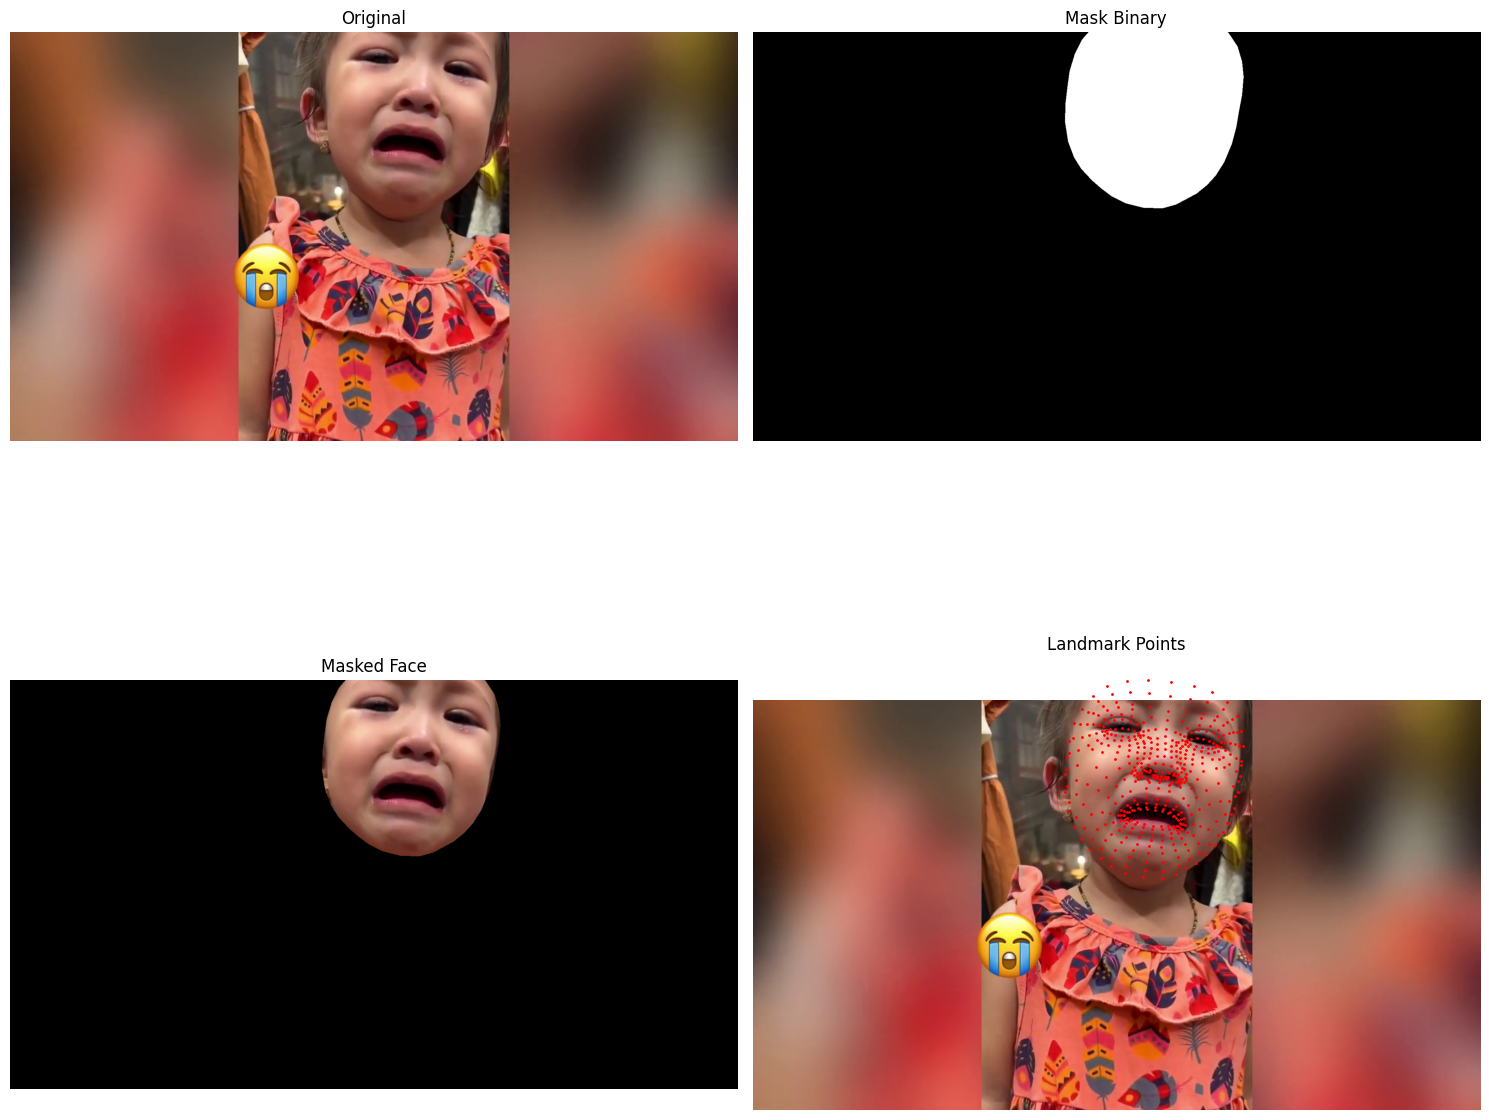

In [ ]:
# 1. LOAD GAMBAR
IMG_PATH = r"D:/KULIAH/S2/Semester 2/Proposal Thesis/TugasIbuHanna Mengarah ke Tugas Akhir/Codingan/Sinta2/frames/frame_225.jpg"
image = cv2.imread(IMG_PATH)
h, w, _ = image.shape

# 2. INISIALISASI MEDIAPIPE
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = face_mesh.process(rgb)
if not results.multi_face_landmarks:
    print("Wajah tidak terdeteksi.")
    raise SystemExit
landmarks = results.multi_face_landmarks[0]

# 4. AMBIL TITIK WAJAH → BUAT MASK POLYGON
points = []
for lm in landmarks.landmark:
    x = int(lm.x * w)
    y = int(lm.y * h)
    points.append([x, y])
points = np.array(points, dtype=np.int32)
FACE_CONTOUR = [
    10, 109, 67, 103, 54, 21, 162, 127, 234, 93, 132, 58, 
    172, 136, 150, 149, 176, 148, 152, 377, 400, 379, 365, 
    397, 288, 361, 323, 454, 356, 389, 251, 284, 332, 297, 338
]
face_pts = points[FACE_CONTOUR]

# Buat mask
mask = np.zeros((h, w), dtype=np.uint8)
cv2.fillPoly(mask, [face_pts], 255)

# 5. APPLY MASK (hilangkan background)
masked_face = cv2.bitwise_and(image, image, mask=mask)

# 6. TAMPILKAN 
plt.figure(figsize=(15, 15))
# --- Original ---
plt.subplot(2, 2, 1)
plt.title("Original")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
# --- Mask Binary ---
plt.subplot(2, 2, 2)
plt.title("Mask Binary")
plt.imshow(mask, cmap='gray')
plt.axis("off")
# --- Masked Face ---
plt.subplot(2, 2, 3)
plt.title("Masked Face")
plt.imshow(cv2.cvtColor(masked_face, cv2.COLOR_BGR2RGB))
plt.axis("off")
# --- Landmark on Image ---
plt.subplot(2, 2, 4)
plt.title("Landmark Points")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.scatter(points[:, 0], points[:, 1], s=1, c='red')
plt.axis("off")
plt.tight_layout()
plt.show()


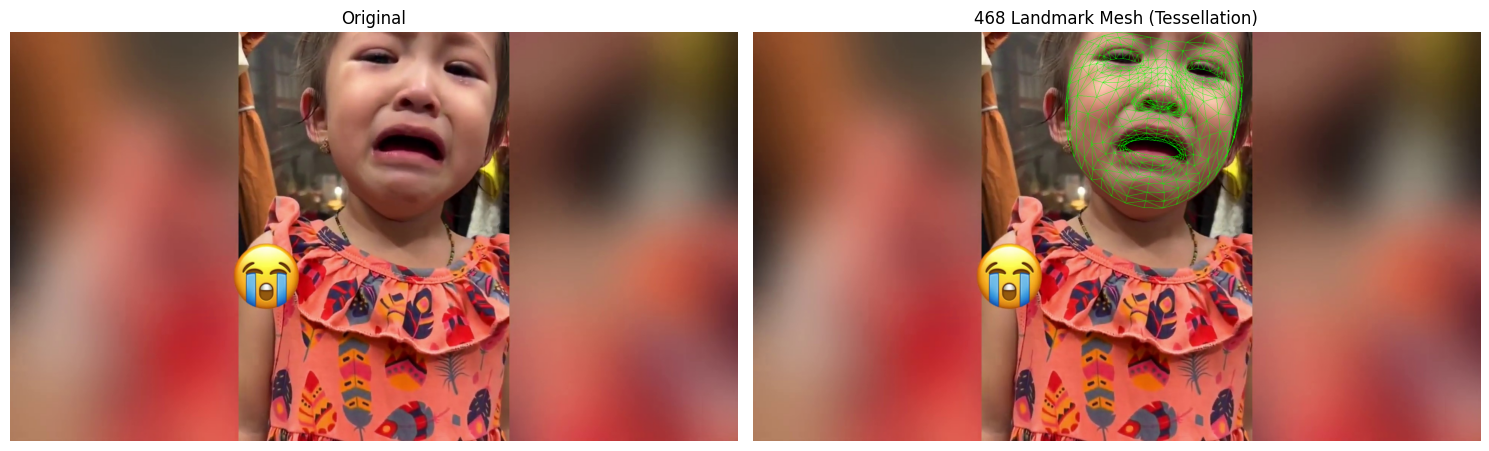

In [4]:
# 1. LOAD GAMBAR
IMG_PATH = r"D:/KULIAH/S2/Semester 2/Proposal Thesis/TugasIbuHanna Mengarah ke Tugas Akhir/Codingan/Sinta2/frames/frame_225.jpg"
image = cv2.imread(IMG_PATH)
h, w, _ = image.shape
# 2. INISIALISASI MEDIAPIPE
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
mp_style = mp.solutions.drawing_styles
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)
# 3. DETEKSI LANDMARK
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = face_mesh.process(rgb)
if not results.multi_face_landmarks:
    print("Wajah tidak terdeteksi.")
    raise SystemExit
landmarks = results.multi_face_landmarks[0]
# 4. EXTRACT SEMUA 468 POINTS
points = []
for lm in landmarks.landmark:
    x = int(lm.x * w)
    y = int(lm.y * h)
    points.append([x, y])
points = np.array(points, dtype=np.int32)
# 5. GAMBAR TESSSELLATION (MESH 468 POINTS)
mesh_img = image.copy()
mp_drawing.draw_landmarks(
    image=mesh_img,
    landmark_list=landmarks,
    connections=mp_face_mesh.FACEMESH_TESSELATION,
    landmark_drawing_spec=None,
    connection_drawing_spec=mp_drawing.DrawingSpec(
        thickness=1,
        circle_radius=0,
        color=(0, 255, 0) 
    )
)
# 6. PLOT HASIL
plt.figure(figsize=(15, 15))
# --- Original ---
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
# --- Mesh 468 Points ---
plt.subplot(1, 2, 2)
plt.title("468 Landmark Mesh (Tessellation)")
plt.imshow(cv2.cvtColor(mesh_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.tight_layout()
plt.show()

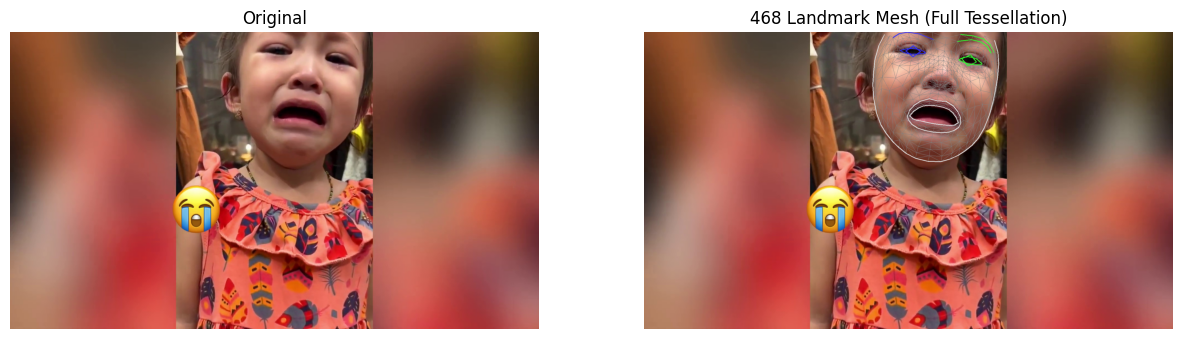

In [21]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt

# Load gambar
IMG_PATH = r"D:/KULIAH/S2/Semester 2/Proposal Thesis/TugasIbuHanna Mengarah ke Tugas Akhir/Codingan/Sinta2/frames/frame_225.jpg"
image = cv2.imread(IMG_PATH)
h, w, _ = image.shape
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Inisialisasi mediapipe
mp_face_mesh = mp.solutions.face_mesh
mp_draw = mp.solutions.drawing_utils
mp_style = mp.solutions.drawing_styles

with mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True,      # → untuk iris
    min_detection_confidence=0.5
) as face_mesh:

    results = face_mesh.process(rgb)

    if not results.multi_face_landmarks:
        print("Tidak ada wajah.")
        raise SystemExit

    annotated = rgb.copy()

    # Gambar FULL TESSELLATION
    mp_draw.draw_landmarks(
        image=annotated,
        landmark_list=results.multi_face_landmarks[0],
        connections=mp_face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp_style.get_default_face_mesh_tesselation_style()
    )

    # Gambar CONTOUR (garis luar wajah, bibir, dll.)
    mp_draw.draw_landmarks(
        image=annotated,
        landmark_list=results.multi_face_landmarks[0],
        connections=mp_face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp_style.get_default_face_mesh_contours_style()
    )

    # Gambar IRIS
    mp_draw.draw_landmarks(
        image=annotated,
        landmark_list=results.multi_face_landmarks[0],
        connections=mp_face_mesh.FACEMESH_IRISES,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp_style.get_default_face_mesh_iris_connections_style()
    )

# Tampilkan
plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(rgb)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("468 Landmark Mesh (Full Tessellation)")
plt.imshow(annotated)
plt.axis("off")

plt.show()


In [ ]:
# 1. LOAD GAMBAR
img_path = "D:\\KULIAH\\S2\\Semester 2\\Proposal Thesis\\TugasIbuHanna Mengarah ke Tugas Akhir\\Codingan\\Sinta2\\frames\\frame_50.jpg" 
image = cv2.imread(img_path)
h, w, _ = image.shape

# Convert to RGB
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 2. FACE MESH SETUP
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)
results = face_mesh.process(rgb)

# 3. MEMBUAT MASK KOSONG
mask = np.zeros((h, w), dtype=np.uint8)

# 4. MENGGAMBAR POLYGON WAJAH
if results.multi_face_landmarks:
    for face_landmarks in results.multi_face_landmarks:
        # Ambil semua koordinat landmark (468 titik)
        points = []
        for lm in face_landmarks.landmark:
            x = int(lm.x * w)
            y = int(lm.y * h)
            points.append([x, y])
        points = np.array(points, dtype=np.int32)
        # Gunakan convex hull untuk bentuk wajah
        hull = cv2.convexHull(points)
        # Menggambar polygon wajah ke mask
        cv2.fillConvexPoly(mask, hull, 255)

# 5. APPLY MASK KE GAMBAR
masked_face = cv2.bitwise_and(image, image, mask=mask)
# 6. SIMPAN HASIL
# ============================================================
output_path = "hasil_masking.png"
cv2.imwrite(output_path, masked_face)
output_path

'hasil_masking.png'

In [6]:
import cv2
import mediapipe as mp

# ============================================================
# 1. LOAD IMAGE
# ============================================================
img_path = "D:\\KULIAH\\S2\\Semester 2\\Proposal Thesis\\TugasIbuHanna Mengarah ke Tugas Akhir\\Codingan\\Sinta2\\frames\\frame_50.jpg"
image = cv2.imread(img_path)
h, w, _ = image.shape

rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# ============================================================
# 2. MEDIAPIPE FACE DETECTION
# ============================================================
mp_face_detection = mp.solutions.face_detection
face_detection = mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

results = face_detection.process(rgb)

# ============================================================
# 3. DRAW BOUNDING BOX IF FACE FOUND
# ============================================================
boxed = image.copy()

if results.detections:
    for detection in results.detections:
        bbox = detection.location_data.relative_bounding_box

        x_min = int(bbox.xmin * w)
        y_min = int(bbox.ymin * h)
        box_w = int(bbox.width * w)
        box_h = int(bbox.height * h)

        # Draw bounding box
        cv2.rectangle(boxed, (x_min, y_min), (x_min + box_w, y_min + box_h), (0, 255, 0), 2)

# ============================================================
# 4. SAVE OUTPUT
# ============================================================
output_path = "hasil_bounding_box.png"
cv2.imwrite(output_path, boxed)

output_path


'hasil_bounding_box.png'

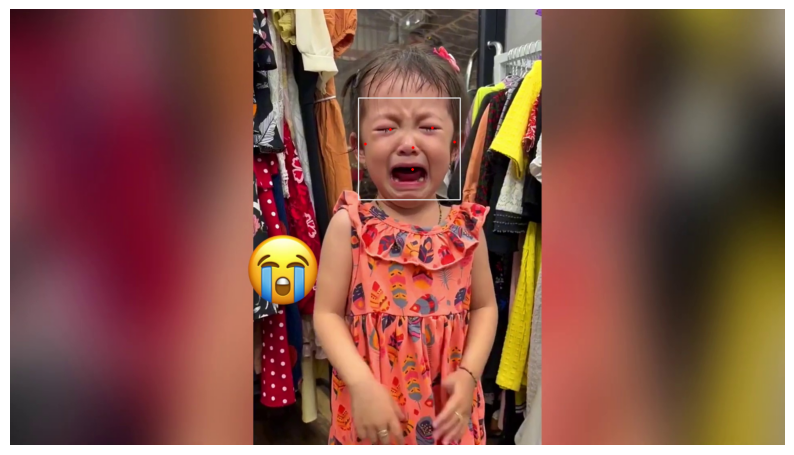

In [ ]:
# 1. LOAD IMAGE
img_path = "D:/KULIAH/S2/Semester 2/Proposal Thesis/TugasIbuHanna Mengarah ke Tugas Akhir/Codingan/Sinta2/frames/frame_50.jpg"
image = cv2.imread(img_path)
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 2. MEDIAPIPE FACE DETECTION
mp_face_detection = mp.solutions.face_detection
mp_draw = mp.solutions.drawing_utils
face_detection = mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)
results = face_detection.process(rgb)

# 3. DRAW BOUNDING BOX with MEDIAPIPE
boxed = image.copy()
if results.detections:
    for detection in results.detections:
        mp_draw.draw_detection(boxed, detection)

# 4. SAVE OUTPUT
output_path = "hasil_bounding_box_mediapipe.png"
cv2.imwrite(output_path, boxed)
output_path

#ploting hasil bounding box mediapipe
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(boxed, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


In [ ]:
mp_face_mesh = mp.solutions.face_mesh
mp_draw = mp.solutions.drawing_utils
mp_styles = mp.solutions.drawing_styles
img_path = "D:/KULIAH/S2/Semester 2/Proposal Thesis/TugasIbuHanna Mengarah ke Tugas Akhir/Codingan/Sinta2/frames/frame_50.jpg"
image = cv2.imread(img_path)
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True,   # <--- supaya 478 titik
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)
results = face_mesh.process(rgb)

# 3. Draw landmarks
boxed = image.copy()

if results.multi_face_landmarks:
    for face_landmarks in results.multi_face_landmarks:
        # Gambar semua 478 landmark dengan style bawaan MediaPipe
        mp_draw.draw_landmarks(
            image=boxed,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_styles.get_default_face_mesh_tesselation_style()
        )
        # Gambar outline wajah
        mp_draw.draw_landmarks(
            image=boxed,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_FACE_OVAL,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_styles.get_default_face_mesh_contours_style()
        )
        # Gambar iris
        mp_draw.draw_landmarks(
            image=boxed,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_IRISES,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_styles.get_default_face_mesh_iris_connections_style()
        )
# 4. Save output
cv2.imwrite("hasil_facemesh_478.png", boxed)

True

#Dengan pengujian terbaru

In [27]:
import pandas as pd
import glob
import os
import re
import numpy as np

# ============================================================
# 1. FOLDER LANDMARKS
# ============================================================
folder_path = r"D:/KULIAH/S2/Semester 2/Proposal Thesis/TugasIbuHanna Mengarah ke Tugas Akhir/Codingan/Sinta2/landmarks/*.csv"
files = glob.glob(folder_path)

print("Total CSV ditemukan:", len(files))

# ============================================================
# 2. LABEL YANG VALID
# ============================================================
valid_labels = ["cry", "laugh", "uh"]

# ============================================================
# 3. FUNCTION EXTRACT LABEL (dari nama file)
# ============================================================
def extract_label(file_name):
    """
    Ambil label dari nama file:
    contoh: frame_0_cry.csv → cry
    """
    for lbl in valid_labels:
        if lbl in file_name.lower():
            return lbl
    return None  # jika tidak ber-label

# ============================================================
# 4. PROSES SEMUA FILE BERLABEL
# ============================================================
data_rows = []
labeled_count = 0

for f in files:
    filename = os.path.basename(f)

    label = extract_label(filename)  # Ambil label dari nama file

    if label is None:
        # skip file yg belum diberi label
        continue

    labeled_count += 1

    df = pd.read_csv(f)

    # Pastikan urut (468 baris)
    df = df.sort_index()

    # Ambil x,y,z → flatten → 1404 fitur
    features = df[["x", "y", "z"]].values.flatten()

    row = [filename] + list(features) + [label]
    data_rows.append(row)

print("Jumlah file berlabel ditemukan:", labeled_count)

# ============================================================
# 5. BUAT DATAFRAME FINAL
# ============================================================
num_features = len(data_rows[0]) - 2  # kecuali filename & label

columns = ["image"] + [f"f{i}" for i in range(num_features)] + ["label"]

df_final = pd.DataFrame(data_rows, columns=columns)

print("Shape dataset final:", df_final.shape)
df_final.head()


Total CSV ditemukan: 283
Jumlah file berlabel ditemukan: 200
Shape dataset final: (200, 1436)


,image,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f1425,f1426,f1427,f1428,f1429,f1430,f1431,f1432,f1433,label
0,frame_0_cry.csv,0.513710,0.348755,-0.016009,0.514842,0.325037,-0.026745,0.513438,0.335637,-0.015180,...,0.530693,0.268001,0.008090,0.527011,0.274677,0.008090,0.531113,0.281568,0.008090,cry
1,frame_1000_laugh.csv,0.540219,0.469600,-0.002136,0.523549,0.443679,-0.014422,0.535721,0.453362,-0.005272,...,0.565536,0.373200,-0.027467,0.561643,0.379989,-0.027467,0.564590,0.389263,-0.027467,laugh
2,frame_1005_laugh.csv,0.540649,0.428015,-0.008513,0.532364,0.401465,-0.019556,0.541868,0.412213,-0.009341,...,0.585054,0.328599,-0.020906,0.578985,0.338063,-0.020906,0.583753,0.348135,-0.020906,laugh
3,frame_100_cry.csv,0.508748,0.359680,-0.016781,0.506362,0.333345,-0.027924,0.507737,0.343833,-0.015610,...,0.536001,0.263341,0.001825,0.530474,0.272701,0.001825,0.536099,0.282427,0.001825,cry
4,frame_1010_laugh.csv,0.549236,0.392092,-0.010963,0.546215,0.364388,-0.026495,0.552513,0.375419,-0.013050,...,0.606033,0.302272,-0.016895,0.598844,0.309658,-0.016895,0.603254,0.321723,-0.016895,laugh


Reading labeled CSVs: 100%|██████████| 200/200 [00:00<00:00, 645.73it/s]


Built dataset X.shape = (200, 1404) y.shape = (200,)
Counts -> total:200 train:150 val:30 test:20
Scaler saved to scaler_landmark.pkl
Epoch 1/100 train_loss=0.9653 val_loss=0.8398 val_acc=0.5000
Saved best model (epoch 1) -> landmark_model.pth
Epoch 2/100 train_loss=0.6226 val_loss=0.6816 val_acc=0.6667
Saved best model (epoch 2) -> landmark_model.pth
Epoch 3/100 train_loss=0.5345 val_loss=0.5937 val_acc=0.7333
Saved best model (epoch 3) -> landmark_model.pth
Epoch 4/100 train_loss=0.4368 val_loss=0.4981 val_acc=0.8000
Saved best model (epoch 4) -> landmark_model.pth
Epoch 5/100 train_loss=0.3790 val_loss=0.6247 val_acc=0.7667
Epoch 6/100 train_loss=0.4168 val_loss=0.4824 val_acc=0.8333
Saved best model (epoch 6) -> landmark_model.pth
Epoch 7/100 train_loss=0.3932 val_loss=0.4777 val_acc=0.8000
Saved best model (epoch 7) -> landmark_model.pth
Epoch 8/100 train_loss=0.2548 val_loss=0.3984 val_acc=0.8333
Saved best model (epoch 8) -> landmark_model.pth
Epoch 9/100 train_loss=0.2822 val_l

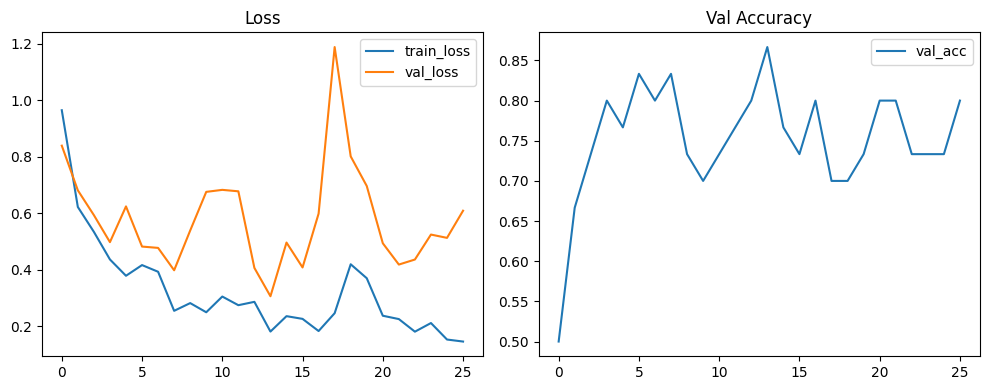

DONE. Model: landmark_model.pth Scaler: scaler_landmark.pkl


In [28]:
# train_landmark_model_full.py
import os
import glob
import random
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# ----------------------------
# CONFIG
# ----------------------------
LANDMARKS_DIR = r"D:/KULIAH/S2/Semester 2/Proposal Thesis/TugasIbuHanna Mengarah ke Tugas Akhir/Codingan/Sinta2/landmarks"
OUT_MODEL = "landmark_model.pth"
OUT_SCALER = "scaler_landmark.pkl"
OUT_HISTORY_PNG = "training_history.png"

VALID_LABELS = ["cry", "laugh", "uh"]
RANDOM_SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Training hyperparams
BATCH_SIZE = 32
EPOCHS = 100
LR = 1e-3
WEIGHT_DECAY = 1e-5
VAL_RATIO = 0.15
TEST_RATIO = 0.10
PATIENCE_ES = 12  # early stopping patience
PATIENCE_LR = 5   # ReduceLROnPlateau patience

# Repro
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# ----------------------------
# HELPERS: LOAD LABELED FILES
# ----------------------------
def collect_labeled_files(landmarks_dir):
    files = glob.glob(os.path.join(landmarks_dir, "*.csv"))
    labeled_files = []
    for f in files:
        fname = os.path.basename(f).lower()
        for lbl in VALID_LABELS:
            if f"_{lbl}.csv" in fname:
                labeled_files.append((f, lbl))
                break
    return labeled_files

# ----------------------------
# BUILD DATAFRAME: 1 ROW PER IMAGE
# ----------------------------
def build_dataset_from_files(labeled_files):
    rows = []
    for fpath, lbl in tqdm(labeled_files, desc="Reading labeled CSVs"):
        df = pd.read_csv(fpath)
        # Try to pick x,y,z columns (if extra cols exist, pick numeric columns)
        if {"x","y","z"}.issubset(set(df.columns)):
            arr = df[["x","y","z"]].values.flatten()
        else:
            # fallback: take numeric columns as they come
            arr = df.select_dtypes(include=[np.number]).values.flatten()
        # ensure length (468*3)
        desired_len = 468 * 3
        if arr.shape[0] < desired_len:
            arr = np.pad(arr, (0, desired_len - arr.shape[0]), mode="constant")
        elif arr.shape[0] > desired_len:
            arr = arr[:desired_len]
        rows.append((os.path.basename(fpath), arr.astype(np.float32), lbl))
    # Create arrays
    images = [r[0] for r in rows]
    X = np.stack([r[1] for r in rows], axis=0)
    y = np.array([VALID_LABELS.index(r[2]) for r in rows], dtype=np.int64)
    return images, X, y

# ----------------------------
# DATASET CLASS
# ----------------------------
class LandmarkArrayDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]), torch.tensor(self.y[idx])

# ----------------------------
# MODEL (custom MLP + small residual)
# ----------------------------
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim)
        )
        self.act = nn.ReLU()
    def forward(self, x):
        return self.act(x + self.fc(x))

class LandmarkNet(nn.Module):
    def __init__(self, input_dim=1404, base=512, n_classes=3):
        super().__init__()
        self.proj = nn.Sequential(
            nn.Linear(input_dim, base),
            nn.LayerNorm(base),
            nn.GELU(),
            nn.Dropout(0.3)
        )
        self.res1 = ResidualBlock(base)
        self.res2 = ResidualBlock(base)
        self.down = nn.Sequential(
            nn.Linear(base, base//2),
            nn.LayerNorm(base//2),
            nn.GELU(),
            nn.Dropout(0.2)
        )
        self.res3 = ResidualBlock(base//2)
        self.head = nn.Sequential(
            nn.Linear(base//2, 128),
            nn.GELU(),
            nn.Dropout(0.15),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        x = self.proj(x)
        x = self.res1(x)
        x = self.res2(x)
        x = self.down(x)
        x = self.res3(x)
        x = self.head(x)
        return x

# ----------------------------
# TRAIN / EVAL UTIL
# ----------------------------
def train_and_evaluate(X, y):
    # split to train/val/test stratified
    idx_all = np.arange(len(y))
    idx_trainval, idx_test = train_test_split(idx_all, test_size=TEST_RATIO, stratify=y, random_state=RANDOM_SEED)
    idx_train, idx_val = train_test_split(idx_trainval, test_size=VAL_RATIO/(1-TEST_RATIO), stratify=y[idx_trainval], random_state=RANDOM_SEED)

    print(f"Counts -> total:{len(y)} train:{len(idx_train)} val:{len(idx_val)} test:{len(idx_test)}")

    # scaler fit on train X
    scaler = StandardScaler()
    scaler.fit(X[idx_train])
    Xs = scaler.transform(X)

    # Save scaler
    joblib.dump(scaler, OUT_SCALER)
    print("Scaler saved to", OUT_SCALER)

    # datasets
    train_ds = LandmarkArrayDataset(Xs[idx_train], y[idx_train])
    val_ds = LandmarkArrayDataset(Xs[idx_val], y[idx_val])
    test_ds = LandmarkArrayDataset(Xs[idx_test], y[idx_test])

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

    # model
    model = LandmarkNet(input_dim=X.shape[1], base=512, n_classes=len(VALID_LABELS)).to(DEVICE)

    # class weights
    class_counts = np.bincount(y[idx_train], minlength=len(VALID_LABELS))
    class_counts = np.maximum(class_counts, 1)
    class_weights = torch.tensor(class_counts.sum() / class_counts, dtype=torch.float32).to(DEVICE)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=PATIENCE_LR)

    best_val_loss = float("inf")
    best_epoch = -1
    no_improve = 0

    history = {"train_loss": [], "val_loss": [], "val_acc": []}

    for epoch in range(1, EPOCHS+1):
        model.train()
        running_loss = 0.0
        for xb, yb in train_loader:
            xb = xb.to(DEVICE).float()
            yb = yb.to(DEVICE)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * xb.size(0)
        train_loss = running_loss / len(train_loader.dataset)

        # validation
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_targs = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(DEVICE).float()
                yb = yb.to(DEVICE)
                logits = model(xb)
                loss = criterion(logits, yb)
                val_loss += loss.item() * xb.size(0)
                preds = logits.argmax(dim=1).cpu().numpy()
                all_preds.extend(preds.tolist())
                all_targs.extend(yb.cpu().numpy().tolist())
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = (np.array(all_preds) == np.array(all_targs)).mean()

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch}/{EPOCHS} train_loss={train_loss:.4f} val_loss={val_loss:.4f} val_acc={val_acc:.4f}")

        scheduler.step(val_loss)

        # early stopping & save best
        if val_loss < best_val_loss - 1e-6:
            best_val_loss = val_loss
            best_epoch = epoch
            no_improve = 0
            torch.save({
                "model_state_dict": model.state_dict(),
                "input_dim": X.shape[1],
                "classes": VALID_LABELS
            }, OUT_MODEL)
            print(f"Saved best model (epoch {epoch}) -> {OUT_MODEL}")
        else:
            no_improve += 1

        if no_improve >= PATIENCE_ES:
            print("Early stopping triggered. No improvement for", PATIENCE_ES, "epochs.")
            break

    # load best model for final test
    ck = torch.load(OUT_MODEL, map_location=DEVICE)
    model.load_state_dict(ck["model_state_dict"])
    model.to(DEVICE).eval()

    # test eval
    y_true = []
    y_pred = []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(DEVICE).float()
            logits = model(xb)
            preds = logits.argmax(dim=1).cpu().numpy()
            y_pred.extend(preds.tolist())
            y_true.extend(yb.numpy().tolist())

    acc_test = accuracy_score(y_true, y_pred)
    print("Test Accuracy:", acc_test)
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=VALID_LABELS))

    # plot history
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history["train_loss"], label="train_loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.legend(); plt.title("Loss")
    plt.subplot(1,2,2)
    plt.plot(history["val_acc"], label="val_acc")
    plt.legend(); plt.title("Val Accuracy")
    plt.tight_layout()
    plt.savefig(OUT_HISTORY_PNG)
    print("Training history saved to", OUT_HISTORY_PNG)
    plt.show()

    return OUT_MODEL, OUT_SCALER

# ----------------------------
# MAIN
# ----------------------------
if __name__ == "__main__":
    labeled_files = collect_labeled_files(LANDMARKS_DIR)
    if len(labeled_files) == 0:
        raise RuntimeError("Tidak ada file berlabel ditemukan di folder " + LANDMARKS_DIR)
    images, X, y = build_dataset_from_files(labeled_files)
    print("Built dataset X.shape =", X.shape, "y.shape =", y.shape)
    model_path, scaler_path = train_and_evaluate(X, y)
    print("DONE. Model:", model_path, "Scaler:", scaler_path)


In [29]:
import numpy as np
import pandas as pd
import glob
import os

# Folder input dan output
input_folder = r"D:/KULIAH/S2/Semester 2/Proposal Thesis/TugasIbuHanna Mengarah ke Tugas Akhir/Codingan/Sinta2/landmarks"
output_folder = r"D:/KULIAH/S2/Semester 2/Proposal Thesis/TugasIbuHanna Mengarah ke Tugas Akhir/Codingan/Sinta2/augmented"

os.makedirs(output_folder, exist_ok=True)

# ---------------------------
# FUNGSI AUGMENTASI
# ---------------------------

def augment_landmarks(df, num_aug=5):
    landmarks = df[['x','y','z']].values
    label = df['label'].iloc[0]
    augmented = []

    for _ in range(num_aug):
        lm = landmarks.copy()

        # 1. Jitter
        jitter = np.random.normal(0, 0.01, lm.shape)
        lm += jitter

        # 2. Scale
        scale = 1 + np.random.uniform(-0.05, 0.05)
        lm *= scale

        # 3. Rotate (small angle)
        angle = np.random.uniform(-5, 5) * np.pi / 180
        R = np.array([
            [np.cos(angle), -np.sin(angle), 0],
            [np.sin(angle),  np.cos(angle), 0],
            [0, 0, 1]
        ])
        lm = lm @ R

        # 4. Noise
        noise = np.random.normal(0, 0.005, lm.shape)
        lm += noise

        # 5. (Opsional) Horizontal flip
        if np.random.rand() > 0.5:
            lm[:, 0] = 1 - lm[:, 0]

        # Buat dataframe baru
        df_aug = pd.DataFrame(lm, columns=['x','y','z'])
        df_aug['label'] = label
        augmented.append(df_aug)

    return augmented

# ---------------------------
# PROSES SEMUA FILE
# ---------------------------

files = glob.glob(os.path.join(input_folder, "*.csv"))
print("Total file ditemukan:", len(files))

for file in files:
    df = pd.read_csv(file)

    # Hanya augmentasi file yang SUDAH ADA labelnya
    if "label" not in df.columns:
        continue

    base = os.path.splitext(os.path.basename(file))[0]

    augmented_list = augment_landmarks(df, num_aug=10)

    for i, aug_df in enumerate(augmented_list):
        out_file = f"{output_folder}/{base}_aug{i}.csv"
        aug_df.to_csv(out_file, index=False)

print("Selesai membuat augmentasi!")


Total file ditemukan: 283
Selesai membuat augmentasi!


In [31]:
import pandas as pd
import numpy as np
import glob
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# ------------------
# LOAD SEMUA CSV
# ------------------
folder = output_folder   # gunakan folder augmentasi
files = glob.glob(folder + "/*.csv")

X = []
y = []

for f in files:
    df = pd.read_csv(f)
    if "label" not in df.columns:
        continue

    X.append(df[['x','y','z']].values.flatten())  # flatten landmark
    y.append(df['label'].iloc[0])

X = np.array(X)
y = np.array(y)

# Encode label
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_enc = le.fit_transform(y)
y_cat = to_categorical(y_enc)

# ------------------
# 5-FOLD TRAINING
# ------------------
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold = 1
acc_scores = []

for train_idx, val_idx in kf.split(X, y_enc):
    print(f"\n===== Fold {fold} =====")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y_cat[train_idx], y_cat[val_idx]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    # ------------------
    # Model MLP
    # ------------------
    model = Sequential([
        Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(y_cat.shape[1], activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=40, batch_size=32, verbose=0)

    # evaluate
    y_pred = np.argmax(model.predict(X_val), axis=1)
    y_true = np.argmax(y_val, axis=1)

    acc = accuracy_score(y_true, y_pred)
    acc_scores.append(acc)

    print("Fold Accuracy:", acc)
    print(classification_report(y_true, y_pred, target_names=le.classes_))

    fold += 1

# ------------------
# MEAN RESULT
# ------------------
print("\n=================================")
print("Mean CV Accuracy =", np.mean(acc_scores))
print("All Fold Accuracy =", acc_scores)



===== Fold 1 =====


d:\KULIAH\S2\Semester 2\Proposal Thesis\TugasIbuHanna Mengarah ke Tugas Akhir\Codingan\Sinta2\Sinta\lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Fold Accuracy: 0.9075
              precision    recall  f1-score   support

         cry       0.90      0.91      0.91       124
       laugh       0.92      0.91      0.91       198
          uh       0.89      0.90      0.89        78

    accuracy                           0.91       400
   macro avg       0.90      0.91      0.90       400
weighted avg       0.91      0.91      0.91       400


===== Fold 2 =====


d:\KULIAH\S2\Semester 2\Proposal Thesis\TugasIbuHanna Mengarah ke Tugas Akhir\Codingan\Sinta2\Sinta\lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Fold Accuracy: 0.8825
              precision    recall  f1-score   support

         cry       0.88      0.94      0.91       124
       laugh       0.93      0.84      0.89       198
          uh       0.79      0.90      0.84        78

    accuracy                           0.88       400
   macro avg       0.87      0.89      0.88       400
weighted avg       0.89      0.88      0.88       400


===== Fold 3 =====


d:\KULIAH\S2\Semester 2\Proposal Thesis\TugasIbuHanna Mengarah ke Tugas Akhir\Codingan\Sinta2\Sinta\lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Fold Accuracy: 0.8975
              precision    recall  f1-score   support

         cry       0.89      0.89      0.89       124
       laugh       0.92      0.91      0.92       198
          uh       0.85      0.87      0.86        78

    accuracy                           0.90       400
   macro avg       0.89      0.89      0.89       400
weighted avg       0.90      0.90      0.90       400


===== Fold 4 =====


d:\KULIAH\S2\Semester 2\Proposal Thesis\TugasIbuHanna Mengarah ke Tugas Akhir\Codingan\Sinta2\Sinta\lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Fold Accuracy: 0.8575
              precision    recall  f1-score   support

         cry       0.96      0.82      0.89       124
       laugh       0.88      0.85      0.86       198
          uh       0.71      0.94      0.81        78

    accuracy                           0.86       400
   macro avg       0.85      0.87      0.85       400
weighted avg       0.87      0.86      0.86       400


===== Fold 5 =====


d:\KULIAH\S2\Semester 2\Proposal Thesis\TugasIbuHanna Mengarah ke Tugas Akhir\Codingan\Sinta2\Sinta\lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Fold Accuracy: 0.9175
              precision    recall  f1-score   support

         cry       0.95      0.93      0.94       124
       laugh       0.91      0.94      0.93       198
          uh       0.88      0.85      0.86        78

    accuracy                           0.92       400
   macro avg       0.91      0.90      0.91       400
weighted avg       0.92      0.92      0.92       400


Mean CV Accuracy = 0.8925000000000001
All Fold Accuracy = [0.9075, 0.8825, 0.8975, 0.8575, 0.9175]


Total labeled CSV files found: 2200
Built X shape: (2200, 1404) y shape: (2200,)
Label classes: ['cry', 'laugh', 'uh']
Train/val split: 1980 220
Saved scaler+labelencoder to scaler_full.pkl


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 512)            │       719,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 887,555 (3.39 MB)

 Trainable params: 885,763 (3.38 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/200

Epoch 1: val_loss improved from None to 0.70036, saving model to final_model.h5


62/62 - 2s - 39ms/step - accuracy: 0.6515 - loss: 0.8291 - val_accuracy: 0.7136 - val_loss: 0.7004 - learning_rate: 0.0010
Epoch 2/200

Epoch 2: val_loss improved from 0.70036 to 0.48720, saving model to final_model.h5


62/62 - 1s - 11ms/step - accuracy: 0.7485 - loss: 0.6059 - val_accuracy: 0.7682 - val_loss: 0.4872 - learning_rate: 0.0010
Epoch 3/200

Epoch 3: val_loss improved from 0.48720 to 0.45235, saving model to final_model.h5


62/62 - 1s - 9ms/step - accuracy: 0.7929 - loss: 0.4923 - val_accuracy: 0.8273 - val_loss: 0.4523 - learning_rate: 0.0010
Epoch 4/200

Epoch 4: val_loss improved from 0.45235 to 0.35881, saving model to final_model.h5


62/62 - 1s - 9ms/step - accuracy: 0.8449 - loss: 0.4053 - val_accuracy: 0.8500 - val_loss: 0.3588 - learning_rate: 0.0010
Epoch 5/200

Epoch 5: val_loss improved from 0.35881 to 0.33970, saving model to final_model.h5


62/62 - 1s - 9ms/step - accuracy: 0.8702 - loss: 0.3432 - val_accuracy: 0.8591 - val_loss: 0.3397 - learning_rate: 0.0010
Epoch 6/200

Epoch 6: val_loss improved from 0.33970 to 0.28236, saving model to final_model.h5


62/62 - 1s - 9ms/step - accuracy: 0.8838 - loss: 0.3023 - val_accuracy: 0.8955 - val_loss: 0.2824 - learning_rate: 0.0010
Epoch 7/200

Epoch 7: val_loss improved from 0.28236 to 0.24807, saving model to final_model.h5


62/62 - 1s - 10ms/step - accuracy: 0.9015 - loss: 0.2663 - val_accuracy: 0.9045 - val_loss: 0.2481 - learning_rate: 0.0010
Epoch 8/200

Epoch 8: val_loss did not improve from 0.24807
62/62 - 1s - 8ms/step - accuracy: 0.8843 - loss: 0.3018 - val_accuracy: 0.9091 - val_loss: 0.2620 - learning_rate: 0.0010
Epoch 9/200

Epoch 9: val_loss improved from 0.24807 to 0.23161, saving model to final_model.h5


62/62 - 1s - 9ms/step - accuracy: 0.9025 - loss: 0.2503 - val_accuracy: 0.9273 - val_loss: 0.2316 - learning_rate: 0.0010
Epoch 10/200

Epoch 10: val_loss did not improve from 0.23161
62/62 - 0s - 8ms/step - accuracy: 0.9202 - loss: 0.2137 - val_accuracy: 0.9045 - val_loss: 0.2673 - learning_rate: 0.0010
Epoch 11/200

Epoch 11: val_loss did not improve from 0.23161
62/62 - 0s - 8ms/step - accuracy: 0.9192 - loss: 0.2179 - val_accuracy: 0.9000 - val_loss: 0.2839 - learning_rate: 0.0010
Epoch 12/200

Epoch 12: val_loss improved from 0.23161 to 0.21886, saving model to final_model.h5


62/62 - 1s - 9ms/step - accuracy: 0.9273 - loss: 0.1782 - val_accuracy: 0.9273 - val_loss: 0.2189 - learning_rate: 0.0010
Epoch 13/200

Epoch 13: val_loss improved from 0.21886 to 0.21859, saving model to final_model.h5


62/62 - 1s - 9ms/step - accuracy: 0.9308 - loss: 0.1904 - val_accuracy: 0.9273 - val_loss: 0.2186 - learning_rate: 0.0010
Epoch 14/200

Epoch 14: val_loss did not improve from 0.21859
62/62 - 1s - 9ms/step - accuracy: 0.9424 - loss: 0.1611 - val_accuracy: 0.9182 - val_loss: 0.2270 - learning_rate: 0.0010
Epoch 15/200

Epoch 15: val_loss did not improve from 0.21859
62/62 - 0s - 8ms/step - accuracy: 0.9263 - loss: 0.1871 - val_accuracy: 0.8955 - val_loss: 0.2448 - learning_rate: 0.0010
Epoch 16/200

Epoch 16: val_loss did not improve from 0.21859
62/62 - 0s - 8ms/step - accuracy: 0.9419 - loss: 0.1653 - val_accuracy: 0.9091 - val_loss: 0.2942 - learning_rate: 0.0010
Epoch 17/200

Epoch 17: val_loss did not improve from 0.21859
62/62 - 0s - 8ms/step - accuracy: 0.9485 - loss: 0.1381 - val_accuracy: 0.9000 - val_loss: 0.2760 - learning_rate: 0.0010
Epoch 18/200

Epoch 18: val_loss improved from 0.21859 to 0.21791, saving model to final_model.h5


62/62 - 1s - 9ms/step - accuracy: 0.9455 - loss: 0.1274 - val_accuracy: 0.9227 - val_loss: 0.2179 - learning_rate: 0.0010
Epoch 19/200

Epoch 19: val_loss did not improve from 0.21791
62/62 - 0s - 8ms/step - accuracy: 0.9611 - loss: 0.1191 - val_accuracy: 0.9227 - val_loss: 0.2435 - learning_rate: 0.0010
Epoch 20/200

Epoch 20: val_loss did not improve from 0.21791
62/62 - 0s - 8ms/step - accuracy: 0.9409 - loss: 0.1457 - val_accuracy: 0.8864 - val_loss: 0.3088 - learning_rate: 0.0010
Epoch 21/200

Epoch 21: val_loss did not improve from 0.21791
62/62 - 0s - 8ms/step - accuracy: 0.9490 - loss: 0.1411 - val_accuracy: 0.8909 - val_loss: 0.2841 - learning_rate: 0.0010
Epoch 22/200

Epoch 22: val_loss did not improve from 0.21791
62/62 - 0s - 8ms/step - accuracy: 0.9601 - loss: 0.1062 - val_accuracy: 0.8955 - val_loss: 0.2940 - learning_rate: 0.0010
Epoch 23/200

Epoch 23: val_loss did not improve from 0.21791
62/62 - 0s - 8ms/step - accuracy: 0.9626 - loss: 0.1002 - val_accuracy: 0.9091 -

Final model saved to final_model.h5
Validation loss: 0.2179, acc: 0.9227
Training history plot saved to training_full_history.png


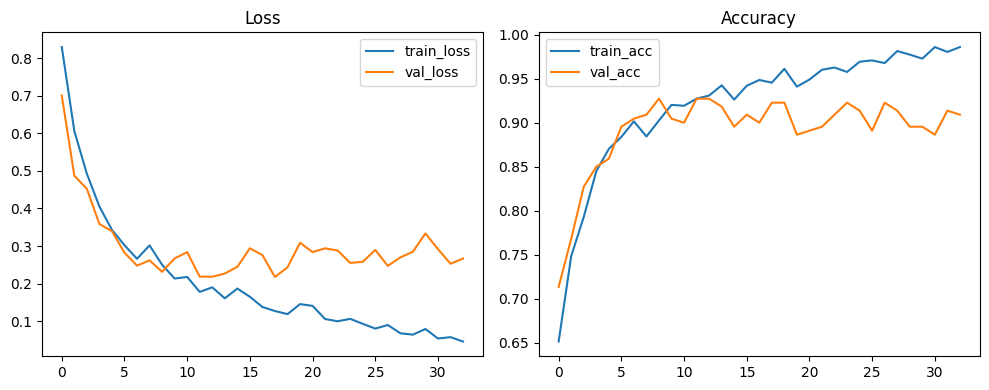

In [32]:
# train_final_model_save_h5.py
import os
import glob
import numpy as np
import pandas as pd
import joblib
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# ====== CONFIGURE PATHS ======
LANDMARKS_DIR = r"D:/KULIAH/S2/Semester 2/Proposal Thesis/TugasIbuHanna Mengarah ke Tugas Akhir/Codingan/Sinta2/landmarks"
AUGMENTED_DIR = r"D:/KULIAH/S2/Semester 2/Proposal Thesis/TugasIbuHanna Mengarah ke Tugas Akhir/Codingan/Sinta2/augmented"  # jika ada
OUT_MODEL = "final_model.h5"
OUT_SCALER = "scaler_full.pkl"
VALID_LABELS = ["cry", "laugh", "uh"]

# ====== UTILS: collect labeled CSVs from folders ======
def collect_csvs(*folders):
    files = []
    for folder in folders:
        if folder is None or not os.path.isdir(folder):
            continue
        files.extend(glob.glob(os.path.join(folder, "*.csv")))
    # filter only labeled files by filename or inside file
    labeled_files = []
    for f in files:
        fn = os.path.basename(f).lower()
        has_label_in_name = any(f"_{lbl}.csv" in fn for lbl in VALID_LABELS)
        if has_label_in_name:
            labeled_files.append(f)
            continue
        # fallback: check inside file for 'label' column
        try:
            df_test = pd.read_csv(f, nrows=1)
            if "label" in df_test.columns:
                labeled_files.append(f)
        except Exception:
            pass
    return sorted(labeled_files)

# ====== BUILD X, y ======
def build_X_y(file_list):
    X_list = []
    y_list = []
    for f in file_list:
        try:
            df = pd.read_csv(f)
        except Exception as e:
            print("Warning: failed reading", f, ":", e)
            continue

        # determine label
        fname = os.path.basename(f).lower()
        label = None
        for lbl in VALID_LABELS:
            if f"_{lbl}.csv" in fname:
                label = lbl
                break
        if label is None:
            if "label" in df.columns:
                label = str(df["label"].iloc[0]).lower()
        if label is None:
            # skip unlabeled file
            continue

        # pick numeric columns: prefer x,y,z
        if {"x","y","z"}.issubset(set(df.columns)):
            arr = df[["x","y","z"]].values.flatten()
        else:
            arr = df.select_dtypes(include=[np.number]).values.flatten()

        # ensure length = 468*3
        desired = 468 * 3
        if arr.shape[0] < desired:
            arr = np.pad(arr, (0, desired - arr.shape[0]), mode="constant")
        elif arr.shape[0] > desired:
            arr = arr[:desired]

        X_list.append(arr.astype(np.float32))
        y_list.append(label)

    X = np.stack(X_list, axis=0)
    y = np.array(y_list)
    return X, y

# ====== MODEL DEFINITION (Keras MLP) ======
def build_model(input_dim, n_classes):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(512),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.Dropout(0.35),

        layers.Dense(256),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.Dropout(0.30),

        layers.Dense(128),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.Dropout(0.15),

        layers.Dense(n_classes, activation="softmax")
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

# ====== MAIN TRAINING FLOW ======
if __name__ == "__main__":
    # collect files from both original labeled folder and augmented folder (if exists)
    files = collect_csvs(LANDMARKS_DIR, AUGMENTED_DIR)
    print("Total labeled CSV files found:", len(files))
    if len(files) == 0:
        raise RuntimeError("Tidak menemukan file CSV berlabel di folder yang diberikan.")

    X, y_text = build_X_y(files)
    print("Built X shape:", X.shape, "y shape:", y_text.shape)

    # encode labels
    le = LabelEncoder()
    y = le.fit_transform(y_text)
    print("Label classes:", list(le.classes_))

    # split train/val (we train final model on train set; keep small val for early stopping)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, stratify=y, random_state=42)
    print("Train/val split:", X_train.shape[0], X_val.shape[0])

    # scale features (fit on train)
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_val_s = scaler.transform(X_val)

    # save scaler
    joblib.dump({"scaler": scaler, "label_encoder": le}, OUT_SCALER)
    print("Saved scaler+labelencoder to", OUT_SCALER)

    # build and train model
    model = build_model(input_dim=X.shape[1], n_classes=len(le.classes_))
    model.summary()

    # callbacks
    es = callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=1)
    ckpt = callbacks.ModelCheckpoint(OUT_MODEL, monitor="val_loss", save_best_only=True, verbose=1)
    reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=6, verbose=1)

    history = model.fit(
        X_train_s, y_train,
        validation_data=(X_val_s, y_val),
        epochs=200,
        batch_size=32,
        callbacks=[es, ckpt, reduce_lr],
        verbose=2
    )

    # save final model (best is already saved by ModelCheckpoint)
    model.save(OUT_MODEL)
    print("Final model saved to", OUT_MODEL)

    # quick evaluation on validation set
    val_loss, val_acc = model.evaluate(X_val_s, y_val, verbose=0)
    print(f"Validation loss: {val_loss:.4f}, acc: {val_acc:.4f}")

    # (optional) plot history
    try:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        plt.plot(history.history["loss"], label="train_loss")
        plt.plot(history.history["val_loss"], label="val_loss")
        plt.legend()
        plt.title("Loss")
        plt.subplot(1,2,2)
        plt.plot(history.history["accuracy"], label="train_acc")
        plt.plot(history.history["val_accuracy"], label="val_acc")
        plt.legend()
        plt.title("Accuracy")
        plt.tight_layout()
        plt.savefig("training_full_history.png")
        print("Training history plot saved to training_full_history.png")
    except Exception as e:
        print("Warning: failed plotting history:", e)


#Prediksi

In [36]:
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 512)            │       719,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 887,557 (3.39 MB)

 Trainable params: 885,763 (3.38 MB)

 Non-trainable params: 1,792 (7.00 KB)

 Optimizer params: 2 (12.00 B)

In [37]:
import cv2
import numpy as np
import mediapipe as mp
from tensorflow.keras.models import load_model

# ============================================================
# 1. LOAD MODEL
# ============================================================
model = load_model("final_model.h5")   # path model Anda

CLASS_NAMES = ["cry", "laugh", "uh"]   # urutan label Anda

# ============================================================
# 2. EKSTRAK LANDMARK (468 titik × x,y,z = 1404 fitur)
# ============================================================
mp_face = mp.solutions.face_mesh

def extract_landmarks(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Gambar tidak ditemukan: " + image_path)

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    with mp_face.FaceMesh(static_image_mode=True, max_num_faces=1) as face_mesh:
        res = face_mesh.process(img_rgb)

        if not res.multi_face_landmarks:
            print("Tidak ada wajah terdeteksi.")
            return None

        face_landmarks = res.multi_face_landmarks[0]

        coords = []
        # Ambil X, Y, Z → total 468 * 3 = 1404 fitur
        for lm in face_landmarks.landmark:
            coords.append([lm.x, lm.y, lm.z])

        coords = np.array(coords).flatten().astype("float32")  # shape = (1404,)
        return coords


# ============================================================
# 3. FUNGSI PREDIKSI EMOSI
# ============================================================
def predict_emotion(image_path):
    landmarks = extract_landmarks(image_path)

    if landmarks is None:
        return "Tidak dapat memprediksi (wajah tidak terdeteksi)", 0.0

    # Bentuk input: (1, 1404)
    X = landmarks.reshape(1, -1)

    pred = model.predict(X)
    class_id = np.argmax(pred)
    confidence = float(np.max(pred))

    return CLASS_NAMES[class_id], confidence


# ============================================================
# 4. TEST PREDIKSI
# ============================================================
# Ganti dengan path gambar Anda
image_path = r"D:/KULIAH/S2/Semester 2/Proposal Thesis/TugasIbuHanna Mengarah ke Tugas Akhir/Codingan/Sinta2/frames/frame_60.jpg"

label, conf = predict_emotion(image_path)

print("Prediksi Emosi :", label)
print("Confidence     :", conf)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Prediksi Emosi : laugh
Confidence     : 0.9869382381439209


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


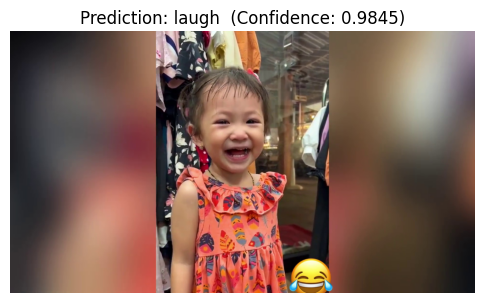

In [39]:
import cv2
import numpy as np
import mediapipe as mp
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# ============================================================
# 1. LOAD MODEL
# ============================================================
model = load_model("final_model.h5")   # path model Anda

CLASS_NAMES = ["cry", "laugh", "uh"]   # urutan label Anda

# ============================================================
# 2. EKSTRAK LANDMARK (468 titik × x,y,z = 1404 fitur)
# ============================================================
mp_face = mp.solutions.face_mesh

def extract_landmarks(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Gambar tidak ditemukan: " + image_path)

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    with mp_face.FaceMesh(static_image_mode=True, max_num_faces=1) as face_mesh:
        res = face_mesh.process(img_rgb)

        if not res.multi_face_landmarks:
            print("Tidak ada wajah terdeteksi.")
            return None, None

        face_landmarks = res.multi_face_landmarks[0]

        coords = []
        for lm in face_landmarks.landmark:
            coords.append([lm.x, lm.y, lm.z])

        coords = np.array(coords).flatten().astype("float32")  # 1404 fitur

        return coords, img_rgb


# ============================================================
# 3. FUNGSI PREDIKSI EMOSI
# ============================================================
def predict_emotion(image_path):
    landmarks, img = extract_landmarks(image_path)

    if landmarks is None:
        return None, 0.0, None

    X = landmarks.reshape(1, -1)
    pred = model.predict(X)

    class_id = np.argmax(pred)
    confidence = float(np.max(pred))
    label = CLASS_NAMES[class_id]

    return label, confidence, img


# ============================================================
# 4. TEST PREDIKSI + TAMPILKAN GAMBAR
# ============================================================
image_path = r"D:/KULIAH/S2/Semester 2/Proposal Thesis/TugasIbuHanna Mengarah ke Tugas Akhir/Codingan/Sinta2/frames/frame_1495.jpg"

label, conf, img = predict_emotion(image_path)

if img is not None:
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Prediction: {label}  (Confidence: {conf:.4f})")
    plt.show()
else:
    print("Prediksi gagal — wajah tidak terdeteksi.")


In [40]:
import cv2
import numpy as np
import mediapipe as mp
from tensorflow.keras.models import load_model
import time

# ============================================================
# 1. LOAD MODEL
# ============================================================
model = load_model("final_model.h5")
CLASS_NAMES = ["cry", "laugh", "uh"]

# ============================================================
# 2. LANDMARK EXTRACTOR
# ============================================================
mp_face = mp.solutions.face_mesh

def extract_landmarks_from_frame(frame):
    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    with mp_face.FaceMesh(static_image_mode=False, max_num_faces=1, refine_landmarks=False) as face_mesh:
        res = face_mesh.process(img_rgb)

        if not res.multi_face_landmarks:
            return None

        face_landmarks = res.multi_face_landmarks[0]

        coords = []
        for lm in face_landmarks.landmark:
            coords.append([lm.x, lm.y, lm.z])

        coords = np.array(coords).flatten().astype("float32")
        return coords


# ============================================================
# 3. REAL-TIME VIDEO PREDICTION
# ============================================================
video_path = r"D:\KULIAH\S2\Semester 2\Proposal Thesis\TugasIbuHanna Mengarah ke Tugas Akhir\Codingan\Sinta2\C7VUCfIXQ3U.f299.mp4"
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Gagal membuka video!")
    exit()

while True:
    ret, frame = cap.read()
    if not ret:
        print("Video selesai.")
        break

    landmarks = extract_landmarks_from_frame(frame)

    if landmarks is not None:
        X = landmarks.reshape(1, -1)
        pred = model.predict(X)

        class_id = np.argmax(pred)
        confidence = float(np.max(pred))
        label = CLASS_NAMES[class_id]

        # Tampilkan teks di video
        text = f"{label} ({confidence:.2f})"
        cv2.putText(frame, text, (30, 40), cv2.FONT_HERSHEY_SIMPLEX,
                    1.0, (0, 255, 0), 2)
    else:
        cv2.putText(frame, "No face detected", (30, 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 2)

    # Tampilkan frame
    cv2.imshow("Emotion Detection (Video)", frame)

    # Tekan 'q' untuk keluar
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━

KeyboardInterrupt: 

#augmented landmark

In [43]:
import os
import numpy as np
import pandas as pd

# ============================================================
# KONFIGURASI
# ============================================================
SOURCE_FOLDER = r"D:/KULIAH/S2/Semester 2/Proposal Thesis/TugasIbuHanna Mengarah ke Tugas Akhir/Codingan/Sinta2/landmarks"
OUTPUT_FOLDER = r"D:/KULIAH/S2/Semester 2/Proposal Thesis/TugasIbuHanna Mengarah ke Tugas Akhir/Codingan/Sinta2/augmented"
AUG_PER_FILE = 5

os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# ============================================================
# FUNGSI AUGMENTASI
# ============================================================

def jitter_noise(landmarks, scale=0.01):
    noise = np.random.normal(0, scale, landmarks.shape)
    return landmarks + noise

def scale_landmarks(landmarks, scale_range=(0.95, 1.05)):
    s = np.random.uniform(scale_range[0], scale_range[1])
    return landmarks * s

def translate_landmarks(landmarks, shift_range=0.01):
    shift = np.random.uniform(-shift_range, shift_range, size=(1, 3))
    return landmarks + shift

def rotate_landmarks(landmarks, angle_range=(-5, 5)):
    angle = np.radians(np.random.uniform(angle_range[0], angle_range[1]))
    cos_a = np.cos(angle)
    sin_a = np.sin(angle)

    R = np.array([
        [cos_a, -sin_a, 0],
        [sin_a,  cos_a, 0],
        [0,      0,     1]
    ])

    return landmarks @ R.T

def augment_once(landmarks):
    lm = landmarks.copy()
    lm = jitter_noise(lm, 0.005)
    lm = scale_landmarks(lm, (0.97, 1.03))
    lm = translate_landmarks(lm, 0.005)
    lm = rotate_landmarks(lm, (-3, 3))
    return lm

# ============================================================
# LOOP - AUGMENTASI OTOMATIS
# ============================================================

files = [f for f in os.listdir(SOURCE_FOLDER) if f.endswith(".csv")]
print(f"Total file asli: {len(files)}")

for file in files:
    path = os.path.join(SOURCE_FOLDER, file)

    try:
        df = pd.read_csv(path)
    except:
        print("Gagal membaca:", file)
        continue

    # Jika ada kolom label, pisahkan
    if "label" in df.columns:
        label = df["label"].iloc[0]
        df_coords = df.drop(columns=["label"])
    else:
        print("Skip: tidak ada label -->", file)
        continue

    # Ambil hanya nilai landmark
    values = df_coords.values.astype("float32")
    
    # Pastikan bentuknya benar: (468, 3)
    if values.shape != (468, 3):
        print("Skip (bukan 468x3):", file, values.shape)
        continue

    # Simpan file asli ke output
    df.to_csv(os.path.join(OUTPUT_FOLDER, file), index=False)

    # Buat augmentasi
    for i in range(AUG_PER_FILE):
        aug = augment_once(values)
        aug_df = pd.DataFrame(aug, columns=df_coords.columns)
        aug_df["label"] = label

        out_name = file.replace(".csv", f"_aug{i+1}.csv")
        out_path = os.path.join(OUTPUT_FOLDER, out_name)

        aug_df.to_csv(out_path, index=False)

    print("Done augment:", file)

print("\n=== SELESAI AUGMENTASI ===")


Total file asli: 283
Skip (bukan 468x3): frame_0_cry.csv (478, 3)
Skip (bukan 468x3): frame_1000_laugh.csv (478, 3)
Skip (bukan 468x3): frame_1005_laugh.csv (478, 3)
Skip (bukan 468x3): frame_100_cry.csv (478, 3)
Skip (bukan 468x3): frame_1010_laugh.csv (478, 3)
Skip (bukan 468x3): frame_1015_laugh.csv (478, 3)
Skip (bukan 468x3): frame_1020_laugh.csv (478, 3)
Skip (bukan 468x3): frame_1025_laugh.csv (478, 3)
Skip (bukan 468x3): frame_1030_laugh.csv (478, 3)
Skip (bukan 468x3): frame_1035_laugh.csv (478, 3)
Skip (bukan 468x3): frame_1040_laugh.csv (478, 3)
Skip (bukan 468x3): frame_1045_laugh.csv (478, 3)
Skip (bukan 468x3): frame_1050_laugh.csv (478, 3)
Skip (bukan 468x3): frame_1055_laugh.csv (478, 3)
Skip (bukan 468x3): frame_105_cry.csv (478, 3)
Skip (bukan 468x3): frame_1060_laugh.csv (478, 3)
Skip (bukan 468x3): frame_1065_laugh.csv (478, 3)
Skip (bukan 468x3): frame_1070_laugh.csv (478, 3)
Skip (bukan 468x3): frame_1075_laugh.csv (478, 3)
Skip (bukan 468x3): frame_1080_laugh.csv

In [44]:
import os
import pandas as pd
import numpy as np

FOLDER = r"D:/KULIAH/S2/Semester 2/Proposal Thesis/TugasIbuHanna Mengarah ke Tugas Akhir/Codingan/Sinta2/landmarks"

# Label valid
LABELS = ["cry", "laugh", "uh"]

# Counter
valid_counts = {"cry": 0, "laugh": 0, "uh": 0}
invalid_files = []

files = [f for f in os.listdir(FOLDER) if f.endswith(".csv")]

print(f"Total file ditemukan: {len(files)}\n")

for file in files:
    path = os.path.join(FOLDER, file)

    # === 1. CEK LABEL DALAM NAMA FILE ===
    label_found = None
    for lab in LABELS:
        if lab in file.lower():
            label_found = lab
            break

    if label_found is None:
        invalid_files.append((file, "tidak ada label"))
        continue

    # === 2. CEK UKURAN LANDMARK ===
    try:
        df = pd.read_csv(path)
        values = df.values.flatten().astype("float32")
    except:
        invalid_files.append((file, "gagal membaca CSV"))
        continue

    if len(values) != 1404:
        invalid_files.append((file, f"ukuran salah ({df.shape})"))
        continue

    # === FILE VALID ===
    valid_counts[label_found] += 1


# ============================================================
# HASIL
# ============================================================

print("=== REKAP DATA VALID PER KELAS ===")
for k, v in valid_counts.items():
    print(f"{k:>6} : {v} file")

print("\n=== TOTAL FILE VALID ===", sum(valid_counts.values()))
print("=== TOTAL FILE INVALID ===", len(invalid_files))

print("\n=== 10 FILE INVALID PERTAMA ===")
for f, reason in invalid_files[:10]:
    print(f"- {f}  --> {reason}")


Total file ditemukan: 283

=== REKAP DATA VALID PER KELAS ===
   cry : 0 file
 laugh : 0 file
    uh : 0 file

=== TOTAL FILE VALID === 0
=== TOTAL FILE INVALID === 283

=== 10 FILE INVALID PERTAMA ===
- frame_0_cry.csv  --> gagal membaca CSV
- frame_1000_laugh.csv  --> gagal membaca CSV
- frame_1005_laugh.csv  --> gagal membaca CSV
- frame_100_cry.csv  --> gagal membaca CSV
- frame_1010_laugh.csv  --> gagal membaca CSV
- frame_1015_laugh.csv  --> gagal membaca CSV
- frame_1020_laugh.csv  --> gagal membaca CSV
- frame_1025_laugh.csv  --> gagal membaca CSV
- frame_1030_laugh.csv  --> gagal membaca CSV
- frame_1035_laugh.csv  --> gagal membaca CSV


In [47]:
import os
import pandas as pd

# ======================================================================
# 1. SETTING: PATH FOLDER LANDMARK
# ======================================================================
folder_path = r"D:/KULIAH/S2/Semester 2/Proposal Thesis/TugasIbuHanna Mengarah ke Tugas Akhir/Codingan/Sinta2/landmarks"   # ganti dengan folder CSV-mu

# ======================================================================
# 2. LOAD SEMUA CSV
# ======================================================================
all_dfs = []
file_list = os.listdir(folder_path)

print("Jumlah file CSV ditemukan:", len(file_list))

for file in file_list:
    if file.endswith(".csv"):
        full_path = os.path.join(folder_path, file)
        df = pd.read_csv(full_path)
        
        # Tambahkan nama file untuk debugging
        df["source_file"] = file
        
        all_dfs.append(df)

if len(all_dfs) == 0:
    raise Exception("Tidak ada file CSV ditemukan. Cek kembali path folder.")

data = pd.concat(all_dfs, ignore_index=True)

print("\nDATASET BERHASIL DIGABUNG!")
print("Total baris:", len(data))

# ======================================================================
# 3. CEK KOLOM APA SAJA
# ======================================================================
print("\nKolom yang ditemukan:")
print(data.columns.tolist())

if "label" not in data.columns:
    print("\n❌ Kolom 'label' TIDAK ditemukan!")
else:
    print("\n✅ Kolom 'label' ditemukan!")

# ======================================================================
# 4. TAMPILKAN SAMPLE DATA
# ======================================================================
print("\nContoh 5 baris data:")
print(data.head())


Jumlah file CSV ditemukan: 283

DATASET BERHASIL DIGABUNG!
Total baris: 135274

Kolom yang ditemukan:
['x', 'y', 'z', 'label', 'source_file']

✅ Kolom 'label' ditemukan!

Contoh 5 baris data:
          x         y         z label      source_file
0  0.513710  0.348755 -0.016009   cry  frame_0_cry.csv
1  0.514842  0.325037 -0.026745   cry  frame_0_cry.csv
2  0.513438  0.335637 -0.015180   cry  frame_0_cry.csv
3  0.508196  0.298141 -0.019990   cry  frame_0_cry.csv
4  0.514585  0.315932 -0.027989   cry  frame_0_cry.csv


In [48]:
# ======================================================================
# 5. REKAP JUMLAH DATA PER KELAS
# ======================================================================

print("\n=== REKAP JUMLAH DATA PER KELAS (TOTAL BARIS) ===")
print(data["label"].value_counts())

print("\n=== REKAP JUMLAH FILE PER KELAS (BERDASARKAN NAMA FILE) ===")
file_labels = [f.split("_")[-1].replace(".csv","") for f in file_list if f.endswith(".csv")]
file_counts = pd.Series(file_labels).value_counts()
print(file_counts)



=== REKAP JUMLAH DATA PER KELAS (TOTAL BARIS) ===
label
laugh    47322
cry      29636
uh       18642
Name: count, dtype: int64

=== REKAP JUMLAH FILE PER KELAS (BERDASARKAN NAMA FILE) ===
laugh    99
cry      62
uh       39
840       1
875       1
         ..
665       1
660       1
655       1
650       1
980       1
Name: count, Length: 86, dtype: int64


In [49]:
# Filter label yang valid
valid_labels = ["cry", "laugh", "uh"]
data = data[data["label"].isin(valid_labels)]
print("\nSetelah filter label valid, total baris:", len(data))


Setelah filter label valid, total baris: 95600


In [50]:
import numpy as np

def augment_landmarks(df, noise_std=0.003):
    """
    df = dataframe 1 file CSV
    """
    arr = df[["x","y","z"]].values

    # Gaussian Noise
    noise = np.random.normal(0, noise_std, arr.shape)
    aug1 = arr + noise

    # Scaling kecil
    scale = 1 + np.random.uniform(-0.03, 0.03)
    aug2 = arr * scale

    # Shift kecil
    shift = np.random.uniform(-0.01, 0.01, size=(1,3))
    aug3 = arr + shift

    # Rotasi kecil di sumbu z (2D rotasi pada x,y)
    theta = np.random.uniform(-3, 3) * np.pi/180
    rot = arr.copy()
    rot_xy = rot[:, :2]
    R = np.array([[np.cos(theta), -np.sin(theta)], 
                  [np.sin(theta),  np.cos(theta)]])
    rot[:, :2] = rot_xy.dot(R)

    # Hasilkan sebagai list dataframes
    dfs = []
    for new_arr in [aug1, aug2, aug3, rot]:
        new_df = df.copy()
        new_df["x"] = new_arr[:,0]
        new_df["y"] = new_arr[:,1]
        new_df["z"] = new_arr[:,2]
        dfs.append(new_df)

    return dfs


In [51]:
TARGET = 47000  

augmented_data = []

for cls in ["cry", "uh"]:
    subset = data[data["label"] == cls]

    need = TARGET - len(subset)

    print(f"Kelas '{cls}' butuh augmentasi: {need} baris")

    # potong per file supaya augmentasi lebih terkontrol
    for file_name in subset["source_file"].unique():
        file_df = subset[subset["source_file"] == file_name]

        # buat augmentasi
        aug_list = augment_landmarks(file_df)

        for aug_df in aug_list:
            augmented_data.append(aug_df)

            need -= len(aug_df)
            if need <= 0:
                break
        if need <= 0:
            break

augmented_data = pd.concat(augmented_data, ignore_index=True)

data_balanced = pd.concat([data, augmented_data], ignore_index=True)
print("\nSetelah augmentasi, total baris dataset:", len(data_balanced))

Kelas 'cry' butuh augmentasi: 17364 baris
Kelas 'uh' butuh augmentasi: 28358 baris

Setelah augmentasi, total baris dataset: 141966


In [53]:
import os
import pandas as pd

FOLDER = r"D:/KULIAH/S2/Semester 2/Proposal Thesis/TugasIbuHanna Mengarah ke Tugas Akhir/Codingan/Sinta2/landmarks"

all_data = []

files = [f for f in os.listdir(FOLDER) if f.endswith(".csv")]

print("Jumlah file CSV ditemukan:", len(files))

for file in files:
    path = os.path.join(FOLDER, file)

    try:
        df = pd.read_csv(path)
        df["source_file"] = file
        all_data.append(df)
    except:
        print("Gagal membaca:", file)

dataset = pd.concat(all_data, ignore_index=True)

dataset.to_csv("dataset_gabungan_final.csv", index=False)

print("DATASET BERHASIL DIGABUNG!")
print("Total baris:", len(dataset))
print("Kolom:", dataset.columns.tolist())


Jumlah file CSV ditemukan: 283
DATASET BERHASIL DIGABUNG!
Total baris: 135274
Kolom: ['x', 'y', 'z', 'label', 'source_file']


In [54]:
import numpy as np
import pandas as pd

# ============================================================
# 1. LOAD DATA GABUNGAN
# ============================================================
df = pd.read_csv("dataset_gabungan_final.csv")

print("Total baris data:", len(df))
print("Kolom:", df.columns.tolist())

# ============================================================
# 2. LIST FILE UNIK → penanda 1 sample = 1 file CSV
# ============================================================
files = df["source_file"].unique()

X_list = []
y_list = []

print("\nTotal sample unik:", len(files))
print("Mulai proses konversi...\n")

# ============================================================
# 3. LOOP PER FILE
# ============================================================
for file in files:
    sub = df[df["source_file"] == file]

    # pastikan 468 baris
    if len(sub) != 468:
        print("Skip (baris != 468):", file)
        continue

    # ambil landmark (x, y, z)
    coords = sub[["x", "y", "z"]].values.astype("float32")

    # reshape ke 1404 fitur
    coords_flat = coords.flatten()  # (468 * 3,)

    # ambil label (semua baris sama)
    label = sub["label"].iloc[0]

    X_list.append(coords_flat)
    y_list.append(label)

# ============================================================
# 4. KONVERSI KE ARRAY NUMPY
# ============================================================
X = np.array(X_list, dtype="float32")
y = np.array(y_list)

print("\n=== KONVERSI SELESAI ===")
print("X shape :", X.shape)     # (jumlah_sample, 1404)
print("y shape :", y.shape)     # (jumlah_sample,)

# ============================================================
# 5. SIMPAN KE FILE
# ============================================================
np.save("X.npy", X)
np.save("y.npy", y)

print("\nFile tersimpan:")
print("- X.npy")
print("- y.npy")

print("\nDataset siap untuk training!")


D:\Tempt\ipykernel_12984\2063914342.py:7: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("dataset_gabungan_final.csv")


Total baris data: 135274
Kolom: ['x', 'y', 'z', 'label', 'source_file']

Total sample unik: 283
Mulai proses konversi...

Skip (baris != 468): frame_0_cry.csv
Skip (baris != 468): frame_1000_laugh.csv
Skip (baris != 468): frame_1005_laugh.csv
Skip (baris != 468): frame_100_cry.csv
Skip (baris != 468): frame_1010_laugh.csv
Skip (baris != 468): frame_1015_laugh.csv
Skip (baris != 468): frame_1020_laugh.csv
Skip (baris != 468): frame_1025_laugh.csv
Skip (baris != 468): frame_1030_laugh.csv
Skip (baris != 468): frame_1035_laugh.csv
Skip (baris != 468): frame_1040_laugh.csv
Skip (baris != 468): frame_1045_laugh.csv
Skip (baris != 468): frame_1050_laugh.csv
Skip (baris != 468): frame_1055_laugh.csv
Skip (baris != 468): frame_105_cry.csv
Skip (baris != 468): frame_1060_laugh.csv
Skip (baris != 468): frame_1065_laugh.csv
Skip (baris != 468): frame_1070_laugh.csv
Skip (baris != 468): frame_1075_laugh.csv
Skip (baris != 468): frame_1080_laugh.csv
Skip (baris != 468): frame_1085_laugh.csv
Skip (b

In [55]:
import os
import numpy as np
import pandas as pd

# ===============================
# PATH DATASET
# ===============================
SOURCE_FOLDER = r"D:/KULIAH/S2/Semester 2/Proposal Thesis/TugasIbuHanna Mengarah ke Tugas Akhir/Codingan/Sinta2/landmarks"

files = [f for f in os.listdir(SOURCE_FOLDER) if f.endswith(".csv")]

X_list = []
y_list = []

valid = 0
invalid = 0

for file in files:
    path = os.path.join(SOURCE_FOLDER, file)
    
    df = pd.read_csv(path)

    # Cek kolom
    if not {"x","y","z","label"}.issubset(df.columns):
        invalid += 1
        continue
    
    # Cek baris harus 468
    if len(df) != 468:
        invalid += 1
        continue

    # Ambil label
    labels = df["label"].unique()

    # Label harus 1 nilai dan tidak kosong
    if len(labels) != 1:
        invalid += 1
        continue

    label = labels[0]

    if pd.isna(label) or label == "":
        invalid += 1
        continue

    # Ambil fitur x,y,z
    coords = df[["x","y","z"]].values.flatten().astype("float32")

    if coords.shape[0] != 1404:
        invalid += 1
        continue

    # Simpan
    X_list.append(coords)
    y_list.append(label)
    valid += 1

print("Valid samples:", valid)
print("Invalid samples:", invalid)

# ===============================
# KONVERSI DATASET KE NUMPY
# ===============================
X = np.array(X_list)
y = np.array(y_list)

print("X shape:", X.shape)
print("y shape:", y.shape)

# ===============================
# SIMPAN KE FILE
# ===============================
np.save("X_landmark.npy", X)
np.save("y_landmark.npy", y)

print("Dataset berhasil disimpan!")


Valid samples: 0
Invalid samples: 283
X shape: (0,)
y shape: (0,)
Dataset berhasil disimpan!


In [69]:
import pandas as pd
import numpy as np

# ============================
# 1. PATH CONFIGURATION
# ============================
CSV_PATH = r"D:\KULIAH\S2\Semester 2\Proposal Thesis\TugasIbuHanna Mengarah ke Tugas Akhir\Codingan\Sinta2\dataset_gabungan_final.csv"
OUTPUT_X = "X_landmarks.npy"
OUTPUT_Y = "y_landmarks.npy"

# ============================
# 2. LOAD DATA (header-safe)
# ============================
print("Loading dataset...")
df = pd.read_csv(CSV_PATH, header=0, low_memory=False)
print(f"Total rows in CSV: {len(df)}")

# ============================
# 3. FILTER LABEL KOSONG
# ============================
df = df.dropna(subset=["label"])
df = df[df["label"].str.strip() != ""]
print(f"Rows after filtering empty labels: {len(df)}")

# ============================
# 4. KONVERSI KOORDINAT KE FLOAT
# ============================
df["x"] = df["x"].astype(float)
df["y"] = df["y"].astype(float)
df["z"] = df["z"].astype(float)

# ============================
# 5. GROUP BY FRAME & RESHAPE
# ============================
samples = []
labels = []

for fname, group in df.groupby("source_file"):
    if len(group) != 468:
        continue  # skip frame tidak lengkap
    coords = group[["x","y","z"]].values.flatten()
    samples.append(coords)
    labels.append(group["label"].iloc[0])

# ============================
# 6. CONVERT TO NUMPY
# ============================
if len(samples) > 0:
    X = np.array(samples)
    y = np.array(labels)
else:
    X = np.empty((0, 468*3))
    y = np.array([])

# ============================
# 7. SUMMARY (SAFE)
# ============================
print("\nDataset Summary:")
print(f"Number of valid frames: {X.shape[0]}")
if X.shape[0] > 0:
    print(f"Number of features per frame: {X.shape[1]}")
    print(f"Unique labels: {np.unique(y)}")
    unique, counts = np.unique(y, return_counts=True)
    print("\nLabel distribution:")
    for u, c in zip(unique, counts):
        print(f"{u}: {c} frames")
else:
    print("No valid frames found!")

# ============================
# 8. SAVE TO NPZ/NPY
# ============================
np.save(OUTPUT_X, X)
np.save(OUTPUT_Y, y)
print(f"\nSaved X to {OUTPUT_X} and y to {OUTPUT_Y}")


Loading dataset...
Total rows in CSV: 135274
Rows after filtering empty labels: 95600

Dataset Summary:
Number of valid frames: 0
No valid frames found!

Saved X to X_landmarks.npy and y to y_landmarks.npy


In [70]:
import pandas as pd
import numpy as np
from collections import Counter

# ============================
# 1. PATH CONFIGURATION
# ============================
CSV_PATH = r"D:/KULIAH/S2/Semester 2/Proposal Thesis/TugasIbuHanna Mengarah ke Tugas Akhir/Codingan/Sinta2/dataset_gabungan_final.csv"
OUTPUT_X = "X_landmarks.npy"
OUTPUT_Y = "y_landmarks.npy"

# ============================
# 2. LOAD DATA
# ============================
print("Loading dataset...")
df = pd.read_csv(CSV_PATH, header=0, low_memory=False)
print(f"Total rows in CSV: {len(df)}")

# ============================
# 3. FILTER LABEL KOSONG
# ============================
df = df.dropna(subset=["label"])
df = df[df["label"].str.strip() != ""]
print(f"Rows after filtering empty labels: {len(df)}")

# ============================
# 4. KONVERSI KOORDINAT KE FLOAT
# ============================
df["x"] = pd.to_numeric(df["x"], errors="coerce")
df["y"] = pd.to_numeric(df["y"], errors="coerce")
df["z"] = pd.to_numeric(df["z"], errors="coerce")
df = df.dropna(subset=["x","y","z"])  # hapus baris yang gagal konversi

# ============================
# 5. GROUP BY FRAME & RESHAPE
# ============================
samples = []
labels = []
failed_frames = []

for fname, group in df.groupby("source_file"):
    if len(group) != 468:
        failed_frames.append((fname, len(group), group["label"].iloc[0]))
        continue  # skip frame tidak lengkap
    coords = group[["x","y","z"]].values.flatten()
    samples.append(coords)
    labels.append(group["label"].iloc[0])

X = np.array(samples)
y = np.array(labels)

# ============================
# 6. SUMMARY
# ============================
print("\nDataset Summary:")
print(f"Number of valid frames: {X.shape[0]}")
if X.shape[0] > 0:
    print(f"Number of features per frame: {X.shape[1]}")
    print(f"Unique labels: {np.unique(y)}")
else:
    print("No valid frames found!")

# ============================
# 7. FAILED FRAME INFO
# ============================
print("\nFrames skipped (invalid):")
for fname, n_landmarks, lbl in failed_frames:
    print(f"{fname}: {n_landmarks} landmarks, label={lbl}")

failed_labels = [lbl for _,_,lbl in failed_frames]
failed_count = Counter(failed_labels)
print("\nNumber of failed frames per label:")
for lbl, cnt in failed_count.items():
    print(f"{lbl}: {cnt} frames")

# ============================
# 8. SAVE VALID DATA
# ============================
np.save(OUTPUT_X, X)
np.save(OUTPUT_Y, y)
print(f"\nSaved X to {OUTPUT_X} and y to {OUTPUT_Y}")


Loading dataset...
Total rows in CSV: 135274
Rows after filtering empty labels: 95600

Dataset Summary:
Number of valid frames: 0
No valid frames found!

Frames skipped (invalid):
frame_0_cry.csv: 478 landmarks, label=cry
frame_1000_laugh.csv: 478 landmarks, label=laugh
frame_1005_laugh.csv: 478 landmarks, label=laugh
frame_100_cry.csv: 478 landmarks, label=cry
frame_1010_laugh.csv: 478 landmarks, label=laugh
frame_1015_laugh.csv: 478 landmarks, label=laugh
frame_1020_laugh.csv: 478 landmarks, label=laugh
frame_1025_laugh.csv: 478 landmarks, label=laugh
frame_1030_laugh.csv: 478 landmarks, label=laugh
frame_1035_laugh.csv: 478 landmarks, label=laugh
frame_1040_laugh.csv: 478 landmarks, label=laugh
frame_1045_laugh.csv: 478 landmarks, label=laugh
frame_1050_laugh.csv: 478 landmarks, label=laugh
frame_1055_laugh.csv: 478 landmarks, label=laugh
frame_105_cry.csv: 478 landmarks, label=cry
frame_1060_laugh.csv: 478 landmarks, label=laugh
frame_1065_laugh.csv: 478 landmarks, label=laugh
fram

In [71]:
import pandas as pd
import numpy as np

# ============================
# 1. PATH CONFIGURATION
# ============================
CSV_PATH = r"D:/KULIAH/S2/Semester 2/Proposal Thesis/TugasIbuHanna Mengarah ke Tugas Akhir/Codingan/Sinta2/dataset_gabungan_final.csv"
OUTPUT_X = "X_landmarks.npy"
OUTPUT_Y = "y_landmarks.npy"
TARGET_LANDMARKS = 468  # jumlah landmarks per frame

# ============================
# 2. LOAD DATA
# ============================
print("Loading dataset...")
df = pd.read_csv(CSV_PATH, header=0, low_memory=False)
print(f"Total rows in CSV: {len(df)}")

# ============================
# 3. FILTER LABEL KOSONG
# ============================
df = df.dropna(subset=["label"])
df = df[df["label"].str.strip() != ""]
print(f"Rows after filtering empty labels: {len(df)}")

# ============================
# 4. KONVERSI KOORDINAT KE FLOAT
# ============================
df["x"] = df["x"].astype(float)
df["y"] = df["y"].astype(float)
df["z"] = df["z"].astype(float)

# ============================
# 5. GROUP BY FRAME & RESHAPE
# ============================
samples = []
labels = []
skipped_frames = []

for fname, group in df.groupby("source_file"):
    n_landmarks = len(group)
    if n_landmarks < TARGET_LANDMARKS:
        skipped_frames.append((fname, n_landmarks, group["label"].iloc[0]))
        continue
    elif n_landmarks > TARGET_LANDMARKS:
        group = group.iloc[:TARGET_LANDMARKS]  # truncate extra landmarks
    
    coords = group[["x","y","z"]].values.flatten()
    samples.append(coords)
    labels.append(group["label"].iloc[0])

X = np.array(samples)
y = np.array(labels)

# ============================
# 6. SUMMARY
# ============================
print("\nDataset Summary:")
print(f"Number of valid frames: {X.shape[0]}")
if X.shape[0] > 0:
    print(f"Number of features per frame: {X.shape[1]}")
print(f"Unique labels: {np.unique(y)}")

# Label distribution
unique, counts = np.unique(y, return_counts=True)
print("\nLabel distribution:")
for u, c in zip(unique, counts):
    print(f"{u}: {c} frames")

# Skipped frames
if skipped_frames:
    print("\nFrames skipped (less than 468 landmarks):")
    for fname, n, label in skipped_frames:
        print(f"{fname}: {n} landmarks, label={label}")

# ============================
# 7. SAVE TO NPZ/NPY
# ============================
np.save(OUTPUT_X, X)
np.save(OUTPUT_Y, y)
print(f"\nSaved X to {OUTPUT_X} and y to {OUTPUT_Y}")


Loading dataset...
Total rows in CSV: 135274
Rows after filtering empty labels: 95600

Dataset Summary:
Number of valid frames: 200
Number of features per frame: 1404
Unique labels: ['cry' 'laugh' 'uh']

Label distribution:
cry: 62 frames
laugh: 99 frames
uh: 39 frames

Saved X to X_landmarks.npy and y to y_landmarks.npy


In [73]:
import pandas as pd
import numpy as np

# ============================
# 1. PATH CONFIGURATION
# ============================
CSV_PATH = r"D:/KULIAH/S2/Semester 2/Proposal Thesis/TugasIbuHanna Mengarah ke Tugas Akhir/Codingan/Sinta2/dataset_gabungan_final.csv"
OUTPUT_X = "X_landmarks.npy"
OUTPUT_Y = "y_landmarks.npy"
TARGET_LANDMARKS = 468  # jumlah landmarks per frame

# ============================
# 2. LOAD DATA
# ============================
print("Loading dataset...")
df = pd.read_csv(CSV_PATH, header=0, low_memory=False)
print(f"Total rows in CSV: {len(df)}")

# ============================
# 3. FILTER LABEL KOSONG
# ============================
df = df.dropna(subset=["label"])
df = df[df["label"].str.strip() != ""]
print(f"Rows after filtering empty labels: {len(df)}")

# ============================
# 4. KONVERSI KOORDINAT KE FLOAT
# ============================
df["x"] = df["x"].astype(float)
df["y"] = df["y"].astype(float)
df["z"] = df["z"].astype(float)

# ============================
# 5. GROUP BY FRAME & RESHAPE (PAD & TRUNCATE)
# ============================
samples = []
labels = []

for fname, group in df.groupby("source_file"):
    n_landmarks = len(group)
    
    # TRUNCATE jika lebih dari target
    if n_landmarks > TARGET_LANDMARKS:
        group = group.iloc[:TARGET_LANDMARKS]
    
    # PAD jika kurang dari target dengan mengulang landmark terakhir
    elif n_landmarks < TARGET_LANDMARKS:
        last_row = group.iloc[-1:]
        n_pad = TARGET_LANDMARKS - n_landmarks
        pad_rows = pd.concat([last_row]*n_pad, ignore_index=True)
        group = pd.concat([group, pad_rows], ignore_index=True)
    
    coords = group[["x","y","z"]].values.flatten()
    samples.append(coords)
    labels.append(group["label"].iloc[0])

X = np.array(samples)
y = np.array(labels)

# ============================
# 6. SUMMARY
# ============================
print("\nDataset Summary:")
print(f"Number of valid frames: {X.shape[0]}")
if X.shape[0] > 0:
    print(f"Number of features per frame: {X.shape[1]}")
print(f"Unique labels: {np.unique(y)}")

# Label distribution
unique, counts = np.unique(y, return_counts=True)
print("\nLabel distribution:")
for u, c in zip(unique, counts):
    print(f"{u}: {c} frames")

# ============================
# 7. SAVE TO NPZ/NPY
# ============================
np.save(OUTPUT_X, X)
np.save(OUTPUT_Y, y)
print(f"\nSaved X to {OUTPUT_X} and y to {OUTPUT_Y}")


Loading dataset...
Total rows in CSV: 135274
Rows after filtering empty labels: 95600

Dataset Summary:
Number of valid frames: 200
Number of features per frame: 1404
Unique labels: ['cry' 'laugh' 'uh']

Label distribution:
cry: 62 frames
laugh: 99 frames
uh: 39 frames

Saved X to X_landmarks.npy and y to y_landmarks.npy


In [77]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# ============================
# 1. LOAD DATA
# ============================
X = np.load("X_landmarks.npy")  # shape: (num_frames, 468*3)
y = np.load("y_landmarks.npy")  # shape: (num_frames,)

print(f"X shape: {X.shape}, y shape: {y.shape}")

# ============================
# 2. ENCODE LABELS
# ============================
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # convert labels to integers
num_classes = len(le.classes_)

# ============================
# 3. TRAIN-TEST SPLIT
# ============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# ============================
# 4. CONVERT TO TORCH TENSORS
# ============================
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ============================
# 5. DEFINE SIMPLE MLP MODEL
# ============================
class LandmarkClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LandmarkClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        return self.model(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LandmarkClassifier(input_dim=X.shape[1], num_classes=num_classes).to(device)

# ============================
# 6. LOSS & OPTIMIZER
# ============================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ============================
# 7. TRAINING LOOP
# ============================
num_epochs = 1000

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * batch_X.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# ============================
# 8. EVALUATION
# ============================
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy: {accuracy:.4f}\n")
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=le.classes_))


X shape: (200, 1404), y shape: (200,)
Epoch [1/1000], Loss: 1.0624
Epoch [2/1000], Loss: 1.0721
Epoch [3/1000], Loss: 1.0236
Epoch [4/1000], Loss: 1.0106
Epoch [5/1000], Loss: 1.0066
Epoch [6/1000], Loss: 0.9756
Epoch [7/1000], Loss: 0.9526
Epoch [8/1000], Loss: 0.9275
Epoch [9/1000], Loss: 0.8994
Epoch [10/1000], Loss: 0.8757
Epoch [11/1000], Loss: 0.8376
Epoch [12/1000], Loss: 0.8447
Epoch [13/1000], Loss: 0.8382
Epoch [14/1000], Loss: 0.7833
Epoch [15/1000], Loss: 0.7552
Epoch [16/1000], Loss: 0.7609
Epoch [17/1000], Loss: 0.7688
Epoch [18/1000], Loss: 0.8087
Epoch [19/1000], Loss: 0.7339
Epoch [20/1000], Loss: 0.7396
Epoch [21/1000], Loss: 0.7624
Epoch [22/1000], Loss: 0.7672
Epoch [23/1000], Loss: 0.7609
Epoch [24/1000], Loss: 0.7310
Epoch [25/1000], Loss: 0.7932
Epoch [26/1000], Loss: 0.7480
Epoch [27/1000], Loss: 0.7426
Epoch [28/1000], Loss: 0.7539
Epoch [29/1000], Loss: 0.7582
Epoch [30/1000], Loss: 0.7061
Epoch [31/1000], Loss: 0.7398
Epoch [32/1000], Loss: 0.7261
Epoch [33/1

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()  
# Load gambar
image_path = "D:/KULIAH/S2/Semester 2/Proposal Thesis/TugasIbuHanna Mengarah ke Tugas Akhir/Codingan/Sinta2/frames/frame_1380.jpg"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Inisialisasi MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
with mp_face_mesh.FaceMesh(static_image_mode=True,
                           max_num_faces=1,
                           refine_landmarks=True,
                           min_detection_confidence=0.5) as face_mesh:
    results = face_mesh.process(image_rgb)
    if results.multi_face_landmarks:
        face_landmarks = results.multi_face_landmarks[0]
        landmarks = [[lm.x, lm.y, lm.z] for lm in face_landmarks.landmark]
        if len(landmarks) >= 468:
            landmarks = np.array(landmarks[:468]).flatten()
            input_tensor = torch.tensor(landmarks, dtype=torch.float32).unsqueeze(0).to(device)
            with torch.no_grad():
                output = model(input_tensor)
                _, pred = torch.max(output, 1)
                predicted_label = le.inverse_transform(pred.cpu().numpy())
            print(f"Predicted expression: {predicted_label[0]}")
        else:
            print("Landmarks kurang dari 468, prediksi gagal.")
    else:
        print("Wajah tidak terdeteksi.")

Predicted expression: uh


In [84]:
import torch
import joblib

# ============================
# 1. SIMPAN MODEL
# ============================
MODEL_PATH = "landmark_mlp_model.pth"
torch.save(model.state_dict(), MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

# ============================
# 2. SIMPAN LABEL ENCODER
# ============================
LE_PATH = "label_encoder.pkl"
joblib.dump(le, LE_PATH)
print(f"LabelEncoder saved to {LE_PATH}")


Model saved to landmark_mlp_model.pth
LabelEncoder saved to label_encoder.pkl


In [15]:
import cv2
import mediapipe as mp
import numpy as np
import torch
import joblib

# ============================
# 1. LOAD MODEL & LABEL ENCODER
# ============================
MODEL_PATH = "landmark_mlp_model.pth"
LE_PATH = "label_encoder.pkl"

le = joblib.load(LE_PATH)
num_classes = len(le.classes_)

class LandmarkClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LandmarkClassifier, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        return self.model(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = 468*3  # fixed landmarks
model = LandmarkClassifier(input_dim=input_dim, num_classes=num_classes).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

# ============================
# 2. SETUP MEDIAPIPE
# ============================
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1)

# ============================
# 3. LOAD VIDEO
# ============================
video_path = r"D:\KULIAH\S2\Semester 2\Proposal Thesis\TugasIbuHanna Mengarah ke Tugas Akhir\Codingan\Sinta2\C7VUCfIXQ3U.f299.mp4"
cap = cv2.VideoCapture(video_path)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb_frame)

    if results.multi_face_landmarks:
        landmarks = []
        for lm in results.multi_face_landmarks[0].landmark[:468]:  # ambil 468 landmarks pertama
            landmarks.extend([lm.x, lm.y, lm.z])
        
        if len(landmarks) == 468*3:
            X_input = torch.tensor([landmarks], dtype=torch.float32).to(device)
            with torch.no_grad():
                output = model(X_input)
                pred_class = torch.argmax(output, dim=1).cpu().item()
                pred_label = le.inverse_transform([pred_class])[0]

            # Tampilkan label prediksi di frame
            cv2.putText(frame, f"Predicted: {pred_label}", (30, 50),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
    
    cv2.imshow("Prediction", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
face_mesh.close()


In [14]:
import torch
from torchsummary import summary

print(model)
summary(model, input_size=(468*3,))


LandmarkClassifier(
  (model): Sequential(
    (0): Linear(in_features=1404, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=256, out_features=3, bias=True)
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         719,360
              ReLU-2                  [-1, 512]               0
           Dropout-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
              ReLU-5                  [-1, 256]               0
           Dropout-6                  [-1, 256]               0
            Linear-7                    [-1, 3]             771
Total params: 851,459
Trainable params: 851,459
Non-trainable params: 0
-------

In [ ]:
# 1. LOAD MODEL & LABEL ENCODER
# ============================
MODEL_PATH = "landmark_mlp_model.pth"
LE_PATH = "label_encoder.pkl"
le = joblib.load(LE_PATH)
num_classes = len(le.classes_)
class LandmarkClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LandmarkClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        return self.model(x)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = 468*3
model = LandmarkClassifier(input_dim=input_dim, num_classes=num_classes).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

# 2. SETUP MEDIAPIPE
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1)

# 3. LOAD VIDEO
video_path = r"D:\KULIAH\S2\Semester 2\Proposal Thesis\TugasIbuHanna Mengarah ke Tugas Akhir\Codingan\Sinta2\C7VUCfIXQ3U.f299.mp4"
cap = cv2.VideoCapture(video_path)
frame_count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame_count += 1
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb_frame)
    if results.multi_face_landmarks:
        landmarks = []
        for lm in results.multi_face_landmarks[0].landmark[:468]:
            landmarks.extend([lm.x, lm.y, lm.z])
        if len(landmarks) == 468*3:
            X_input = torch.tensor([landmarks], dtype=torch.float32).to(device)
            with torch.no_grad():
                output = model(X_input)
                probs = F.softmax(output, dim=1).cpu().numpy()[0]
                pred_class = np.argmax(probs)
                pred_label = le.inverse_transform([pred_class])[0]
                confidence = probs[pred_class]
            # Print di cell notebook
            print(f"Frame {frame_count}: Predicted = {pred_label}, Confidence = {confidence:.4f}")
            # Tampilkan label di video
            cv2.putText(frame, f"{pred_label} ({confidence:.2f})", (30, 50),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
    cv2.imshow("Prediction", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()
face_mesh.close()

Frame 1: Predicted = cry, Confidence = 0.9597
Frame 2: Predicted = cry, Confidence = 0.9634
Frame 3: Predicted = cry, Confidence = 0.9684
Frame 4: Predicted = cry, Confidence = 0.9690
Frame 5: Predicted = cry, Confidence = 0.9719
Frame 6: Predicted = cry, Confidence = 0.9721
Frame 7: Predicted = cry, Confidence = 0.9711
Frame 8: Predicted = cry, Confidence = 0.9711
Frame 9: Predicted = cry, Confidence = 0.9716
Frame 10: Predicted = cry, Confidence = 0.9725
Frame 11: Predicted = cry, Confidence = 0.9707
Frame 12: Predicted = cry, Confidence = 0.9709
Frame 13: Predicted = cry, Confidence = 0.9700
Frame 14: Predicted = cry, Confidence = 0.9697
Frame 15: Predicted = cry, Confidence = 0.9716
Frame 16: Predicted = cry, Confidence = 0.9725
Frame 17: Predicted = cry, Confidence = 0.9711
Frame 18: Predicted = cry, Confidence = 0.9721
Frame 19: Predicted = cry, Confidence = 0.9711
Frame 20: Predicted = cry, Confidence = 0.9731
Frame 21: Predicted = cry, Confidence = 0.9705
Frame 22: Predicted = 

#Prediksi Real Time

In [11]:
import cv2
import mediapipe as mp
import torch
import torch.nn as nn
import torch.nn.functional as F
import joblib
import numpy as np

# ============================
# 1. LOAD MODEL & LABEL ENCODER
# ============================
MODEL_PATH = "landmark_mlp_model.pth"
LE_PATH = "label_encoder.pkl"

le = joblib.load(LE_PATH)
num_classes = len(le.classes_)

class LandmarkClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LandmarkClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        return self.model(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = 468*3
model = LandmarkClassifier(input_dim=input_dim, num_classes=num_classes).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

# ============================
# 2. SETUP MEDIAPIPE
# ============================
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1)

# ============================
# 3. REAL-TIME WEBCAM
# ============================
cap = cv2.VideoCapture(0)  # 0 = default webcam
frame_count = 0

print("Starting real-time prediction. Press 'q' to quit.")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb_frame)

    if results.multi_face_landmarks:
        landmarks = []
        for lm in results.multi_face_landmarks[0].landmark[:468]:
            landmarks.extend([lm.x, lm.y, lm.z])
        
        if len(landmarks) == 468*3:
            X_input = torch.tensor([landmarks], dtype=torch.float32).to(device)
            with torch.no_grad():
                output = model(X_input)
                probs = F.softmax(output, dim=1).cpu().numpy()[0]
                pred_class = np.argmax(probs)
                pred_label = le.inverse_transform([pred_class])[0]
                confidence = probs[pred_class]

            # Print di cell notebook
            print(f"Frame {frame_count}: Predicted = {pred_label}, Confidence = {confidence:.4f}")

            # Tampilkan label di frame webcam
            cv2.putText(frame, f"{pred_label} ({confidence:.2f})", (30, 50),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
    
    cv2.imshow("Real-Time Expression Prediction", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
face_mesh.close()


Starting real-time prediction. Press 'q' to quit.
Frame 1: Predicted = laugh, Confidence = 0.9985
Frame 2: Predicted = laugh, Confidence = 0.9988
Frame 3: Predicted = laugh, Confidence = 0.9988
Frame 4: Predicted = laugh, Confidence = 0.9992
Frame 5: Predicted = laugh, Confidence = 0.9992
Frame 6: Predicted = laugh, Confidence = 0.9993
Frame 7: Predicted = laugh, Confidence = 0.9992
Frame 8: Predicted = laugh, Confidence = 0.9994
Frame 9: Predicted = laugh, Confidence = 0.9994
Frame 10: Predicted = laugh, Confidence = 0.9993
Frame 11: Predicted = laugh, Confidence = 0.9992
Frame 12: Predicted = laugh, Confidence = 0.9993
Frame 13: Predicted = laugh, Confidence = 0.9993
Frame 14: Predicted = laugh, Confidence = 0.9994
Frame 15: Predicted = laugh, Confidence = 0.9994
Frame 16: Predicted = laugh, Confidence = 0.9994
Frame 17: Predicted = laugh, Confidence = 0.9993
Frame 18: Predicted = laugh, Confidence = 0.9992
Frame 19: Predicted = laugh, Confidence = 0.9992
Frame 20: Predicted = laugh,